In [1]:

%pprint
import sys
import os.path as osp

if (osp.abspath(osp.join('..', 'py')) not in sys.path): sys.path.insert(1, osp.abspath(osp.join('..', 'py')))

from StatsByCountry import (all_countries_df, cu, nu, scu, ssu)
from itertools import combinations
from pandas import DataFrame, concat
from tqdm import tqdm
import humanize
import networkx as nx
import numpy as np
import pyperclip
import pyttsx3
import re
import time
import matplotlib.pyplot as plt

Pretty printing has been turned OFF



## Create the border data frame

In [2]:

# Scrape the border data
if nu.pickle_exists('country_borders_df'): borders_df = nu.load_object('country_borders_df')
else:
    
    # geojson_url = 'https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM0.geojson'
    # shapefile_url = 'https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM0.zip'
    # geopackage_url = 'https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM0.gpkg'
    # factbook_url = 'https://www.cia.gov/the-world-factbook/field/land-boundaries/'
    # ipfs_url = 'https://en.wikipedia-on-ipfs.org/wiki/List_of_countries_and_territories_by_land_borders'
    # tables_url = 'https://en.wikipedia.org/wiki/List_of_political_and_geographic_borders'
    # tables_url = 'https://en.wikipedia.org/wiki/List_of_countries_and_territories_by_land_and_maritime_borders'
    tables_url = 'https://en.wikipedia.org/wiki/List_of_countries_and_territories_by_number_of_land_borders'
    table_dfs_list = nu.get_wiki_tables(tables_url, verbose=False)
    borders_df = table_dfs_list[0].copy()
    borders_df.columns = ['country_name', 'length_km', 'length_mi', 'borders_count', 'neighbors_count', 'neighbors_notes']
    
    # Clean up the country names
    borders_df.country_name = borders_df.country_name.map(lambda x: str(x).split('[')[0])
    borders_df.country_name = borders_df.country_name.map(lambda x: re.sub(', Metropolitan', '', str(x)))
    borders_df.country_name = borders_df.country_name.map(lambda x: re.sub(' \(constituent country\)', '', str(x)))
    borders_df.country_name = borders_df.country_name.map(lambda x: re.sub('^The ', '', str(x)))
    mask_series = borders_df.country_name.map(lambda x: bool(re.search('including ', str(x))))
    borders_df = borders_df[~mask_series]
    mask_series = borders_df.country_name.map(lambda x: bool(re.search('includes:', str(x))))
    borders_df = borders_df[~mask_series]
    
    # Clean up the neighbors lists
    neighbors_list = [x.replace('.', r'\.').replace('(', r'\(').replace(')', r'\)') for x in sorted(borders_df.country_name)]
    neighbors_regex = re.compile(r'\b(' + '|'.join(neighbors_list) + r')\b')
    borders_df['neighbors_list'] = borders_df.neighbors_notes.map(lambda x: neighbors_regex.split(str(x).replace('\xa0', ' '))).map(lambda x: x[1::2])
    
    # Fix the consideration of the Straight of Gilbraltor as a border
    mask_series = borders_df.country_name.map(lambda x: bool(re.search("Spain", str(x))))
    if mask_series.any():
        neighbors_list = borders_df.loc[mask_series, 'neighbors_list'].apply(lambda x: list(set(x) - {'Morocco'}))
        borders_df.loc[mask_series, 'neighbors_list'] = neighbors_list
    mask_series = borders_df.country_name.map(lambda x: bool(re.search("Morocco", str(x))))
    if mask_series.any():
        neighbors_list = borders_df.loc[mask_series, 'neighbors_list'].apply(lambda x: list(set(x) - {'Spain'}))
        borders_df.loc[mask_series, 'neighbors_list'] = neighbors_list

    nu.store_objects(country_borders_df=borders_df, verbose=True)
borders_df.sample(5).T

,76,120,106,24,192
country_name,Honduras,Moldova,Luxembourg,Brunei,Ukraine
length_km,1520.0,1389.0,359.0,381.0,4663.0
length_mi,940,863,223,237,2897
borders_count,3,2,3,1,8
neighbors_count,3,2,3,1,7
neighbors_notes,Guatemala: 256 km (159 mi) El Salvador: 342 km...,Romania: 450 km (280 mi) Ukraine: 939 km (583 mi),Belgium: 148 km (92 mi) France: 73 km (45 mi) ...,Malaysia (2): 381 km (237 mi),Belarus: 891 km (554 mi) Hungary: 103 km (64 m...
neighbors_list,"[Guatemala, El Salvador, Nicaragua]","[Romania, Ukraine]","[Belgium, France, Germany]",[Malaysia],"[Belarus, Hungary, Moldova, Poland, Romania, R..."


In [3]:

# Prove that Spain doesn't have Morocco as one of its neighbors
mask_series = borders_df.country_name.map(lambda x: bool(re.search("Spain", str(x))))
borders_df[mask_series]

,country_name,length_km,length_mi,borders_count,neighbors_count,neighbors_notes,neighbors_list
173,Spain,1918.0,1192,9,5,Andorra: 63.7 km (39.6 mi) France (3):[w] 623 ...,"[Andorra, United Kingdom, France, Portugal]"


In [4]:

# Prove Morocco doesn't have Spain as one of its neighbors
mask_series = borders_df.country_name.map(lambda x: bool(re.search("Morocco", str(x))))
borders_df[mask_series]

,country_name,length_km,length_mi,borders_count,neighbors_count,neighbors_notes,neighbors_list
124,Morocco,2018.0,1254,5,3,"Algeria: 1,559 km (969 mi) Western Sahara:[d] ...","[Algeria, Western Sahara]"


In [5]:

centroids_dict = {k: np.array([ssu.parse_to_decimal(v)[0], ssu.parse_to_decimal(v)[1]]) for k, v in ssu.country_centroids_dict.items()}


----
## Convert the borders into edges and the countries into nodes

In [6]:

# Initialize an undirected graph; add nodes from unique country names
ALL_COUNTRIES_GRAPH = nx.Graph()
ALL_COUNTRIES_GRAPH.add_nodes_from(centroids_dict.keys())

# Add edges based on country borders dictionary
border_set = set()
for country, neighbors in ssu.country_borders_dict.items():
    for neighbor in neighbors:
        bordering_str = str(sorted([country, neighbor]))
        border_set.add(bordering_str)
for bordering_str in border_set:
    country, neighbor = eval(bordering_str)
    ALL_COUNTRIES_GRAPH.add_edge(country, neighbor)


----

In [75]:

def plot_by_layout(sub_graph, pos_dict, countries_list, countries_label, graph_title, verbose=False):
    
    # Create a figure and axes
    height_inches = 6
    width_inches = height_inches * nu.twitter_aspect_ratio
    size_inches_tuple = (width_inches, height_inches)
    fig, ax = plt.subplots(figsize=size_inches_tuple)
    
    # Draw the subgraph
    nx.draw_networkx_edges(sub_graph, pos_dict, alpha=.5, ax=ax)
    nx.draw_networkx_labels(sub_graph, pos_dict, labels={n: n for n in sub_graph.nodes if n != 'Israel'}, font_size=8, font_weight='bold', alpha=.75, ax=ax)
    nx.draw_networkx_labels(sub_graph, pos_dict, labels={'Israel': 'Israel'}, font_size=10, font_weight='bold', font_color='white', ax=ax)
    
    # Draw nodes for parameter countries
    nx.draw_networkx_nodes(sub_graph, pos_dict, nodelist=countries_list, node_size=2000, node_color='red', edgecolors='gray', label=countries_label, alpha=.5, ax=ax)
    
    # Draw nodes for bordering countries
    nx.draw_networkx_nodes(
        sub_graph, pos_dict, nodelist=set(sub_graph.nodes).difference(set(countries_list + ['Israel'])), node_size=2000, node_color='lightgreen', edgecolors='gray',
        label='Bordering Countries', alpha=.5, ax=ax
    )
    
    # Draw node for Israel
    nx.draw_networkx_nodes(sub_graph, pos_dict, nodelist=['Israel'], node_size=1400, node_color='blue', edgecolors='blue', label='Israel', ax=ax)
    
    # Set title
    ax.set_title(graph_title)
    
    # Place the legend outside the plot with smaller markers
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., markerscale=0.5)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Set limits to prevent clipping of top and bottom nodes
    padding = 0.2
    y_values = [pos[1] for node, pos in pos_dict.items()]
    if verbose:
        print(pos_dict)
        print(countries_list)
    ax.set_ylim(min(y_values) - padding, max(y_values) + padding)
    
    # Show the plot
    plt.show()

In [87]:

# Check that the conversion works
corners_dict = {
    "Left Bottom (Southwest)": (-180.0, -60.0),
    "Left Top (Northwest)": (-180.0, 85.0),
    "Right Bottom (Southeast)": (180.0, -60.0),
    "Right Top (Northeast)": (180.0, 85.0)
}

def convert_coordinates(lat, lon, min_lat, max_lat, min_lon, max_lon):
    """
    Convert latitude and longitude to a new coordinate system.

    Parameters:
    lat (float): Latitude of the point.
    lon (float): Longitude of the point.
    min_lat (float): Minimum latitude of the bounding box.
    max_lat (float): Maximum latitude of the bounding box.
    min_lon (float): Minimum longitude of the bounding box.
    max_lon (float): Maximum longitude of the bounding box.

    Returns:
    tuple: (new_x, new_y) in the new coordinate system.
    """
    # Normalize longitude
    if max_lon != min_lon:
        new_x = 2 * (lon - min_lon) / (max_lon - min_lon) - 1
    else:
        new_x = 0  # or handle the case where max_lon == min_lon differently
    
    # Normalize latitude
    if max_lat != min_lat:
        new_y = 2 * (lat - min_lat) / (max_lat - min_lat) - 1
    else:
        new_y = 0  # or handle the case where max_lat == min_lat differently
    
    return np.array([new_x, new_y])

# Get the cardinal points
min_lat_tuple = min([(c, centroids_dict[c]) for c in centroids_dict.keys()], key=lambda x: x[1][0])
min_lat = min_lat_tuple[1]
print(f'The Southernmost point is {min_lat_tuple[0]} at {min_lat} (', end='')
min_lat = min(corners_dict.values(), key=lambda x: x[0])[0]
print(f'{min_lat})')
min_lat = min_lat_tuple[1][0]

max_lat_tuple = max([(c, centroids_dict[c]) for c in centroids_dict.keys()], key=lambda x: x[1][0])
max_lat = max_lat_tuple[1]
print(f'The Northernmost point is {max_lat_tuple[0]} at {max_lat} (', end='')
max_lat = max(corners_dict.values(), key=lambda x: x[0])[0]
print(f'{max_lat})')
max_lat = max_lat_tuple[1][0]

min_lon_tuple = min([(c, centroids_dict[c]) for c in centroids_dict.keys()], key=lambda x: x[1][1])
min_lon = min_lon_tuple[1]
print(f'The Westernmost point is {min_lon_tuple[0]} at {min_lon} (', end='')
min_lon = min(corners_dict.values(), key=lambda x: x[1])[1]
print(f'{min_lon})')

max_lon_tuple = max([(c, centroids_dict[c]) for c in centroids_dict.keys()], key=lambda x: x[1][1])
max_lon = max_lon_tuple[1]
print(f'The Easternmost point is {max_lon_tuple[0]} at {max_lon} (', end='')
max_lon = max(corners_dict.values(), key=lambda x: x[1])[1]
print(f'{max_lon})')

earth_pos_dict = {k: convert_coordinates(v[0], v[1], min_lat, max_lat, min_lon, max_lon) for k, v in centroids_dict.items()}

# Convert corners
top_left = convert_coordinates(corners_dict['Left Top (Northwest)'][0], corners_dict['Left Top (Northwest)'][1], min_lat, max_lat, min_lon, max_lon)
top_right = convert_coordinates(corners_dict['Right Top (Northeast)'][0], corners_dict['Right Top (Northeast)'][1], min_lat, max_lat, min_lon, max_lon)
bottom_left = convert_coordinates(corners_dict['Left Bottom (Southwest)'][0], corners_dict['Left Bottom (Southwest)'][1], min_lat, max_lat, min_lon, max_lon)
bottom_right = convert_coordinates(corners_dict['Right Bottom (Southeast)'][0], corners_dict['Right Bottom (Southeast)'][1], min_lat, max_lat, min_lon, max_lon)

print('Left Top (Northwest):', top_left)
print('Right Top (Northeast):', top_right)
print('Left Bottom (Southwest):', bottom_left)
print('Right Bottom (Southeast):', bottom_right)

The Southernmost point is Antarctica at [-90.   0.] (-180.0)
The Northernmost point is Arctic Ocean at [90.  0.] (180.0)
The Westernmost point is Midway Islands at [  28.2        -177.36666667] (-60.0)
The Easternmost point is Tuvalu at [ -8. 178.] (85.0)
Left Top (Northwest): [ 1. -2.]
Right Top (Northeast): [1. 2.]
Left Bottom (Southwest): [-1. -2.]
Right Bottom (Southeast): [-1.  2.]



## Add the border countries

In [56]:

def get_border_countries(source_countries, verbose=False):
    countries_set = set()
    
    # Generate all unique pairs
    pairs = list(combinations(source_countries, 2))
    
    if verbose:
        t1 = time.time()
        speech_engine = pyttsx3.init()
        progress_bar = tqdm(
            pairs, total=len(pairs),
            desc="Find Shortest Paths"
        )
    else:
        progress_bar = pairs
    for source, target in progress_bar:
        generator_obj = nx.all_shortest_paths(ALL_COUNTRIES_GRAPH, source, target)
        for countries_list in generator_obj:
            countries_set.update(countries_list)

    if verbose:
        duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
        speech_str = f'All countries added in {duration_str}'
        print(speech_str); speech_engine.say(speech_str); speech_engine.runAndWait()
    
    return countries_set

In [57]:

# Create a subgraph from the original graph
psalm83_list = ['Egypt', 'Iraq', 'Jordan', 'Lebanon', 'Palestine', 'Saudi Arabia', 'Syria']
psalm83_countries_set = get_border_countries(psalm83_list, verbose=False)
print(psalm83_countries_set)
psalm83_graph = ALL_COUNTRIES_GRAPH.subgraph(psalm83_countries_set)

{'Syria', 'Palestine', 'Lebanon', 'Iraq', 'Egypt', 'Saudi Arabia', 'Israel', 'Jordan'}


In [58]:

# Create an Ezekiel 38 subgraph from the original graph
ezekiel38_list = ['Russia', 'Türkiye', 'Iran', 'Sudan', 'Ethiopia', 'Libya', 'Belarus']
ezekiel38_countries_set = get_border_countries(ezekiel38_list, verbose=False)
print(ezekiel38_countries_set)
ezekiel38_graph = ALL_COUNTRIES_GRAPH.subgraph(ezekiel38_countries_set)

{'Syria', 'Palestine', 'Sudan', 'Russia', 'Libya', 'Georgia', 'Ethiopia', 'Belarus', 'Egypt', 'Iraq', 'Israel', 'Iran', 'Jordan', 'Türkiye', 'Azerbaijan'}



----

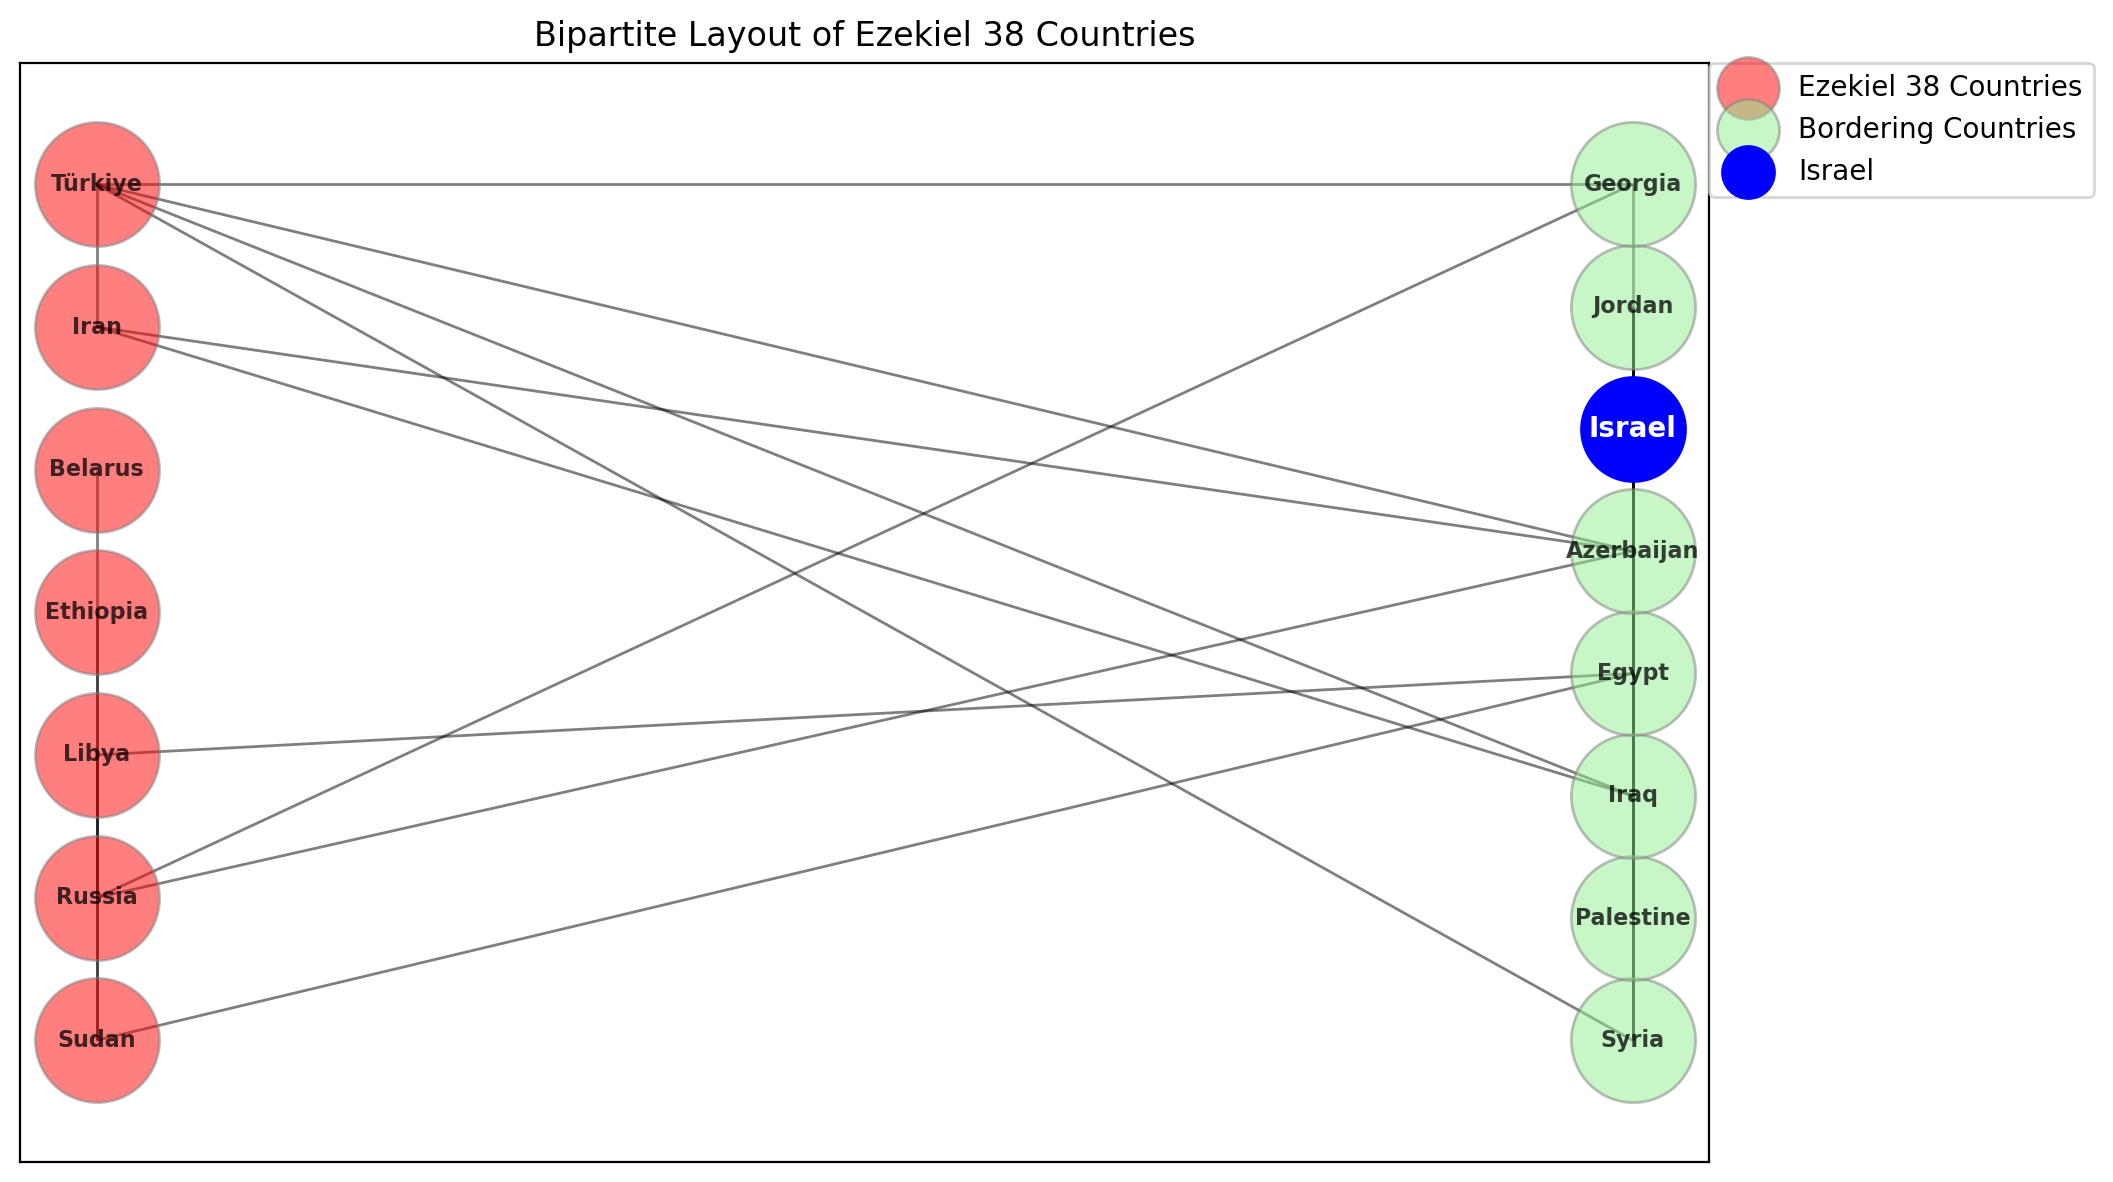

In [59]:

plot_by_layout(
    ezekiel38_graph, nx.bipartite_layout(ezekiel38_graph, nodes=ezekiel38_list), countries_list=ezekiel38_list, countries_label='Ezekiel 38 Countries', graph_title='Bipartite Layout of Ezekiel 38 Countries'
)

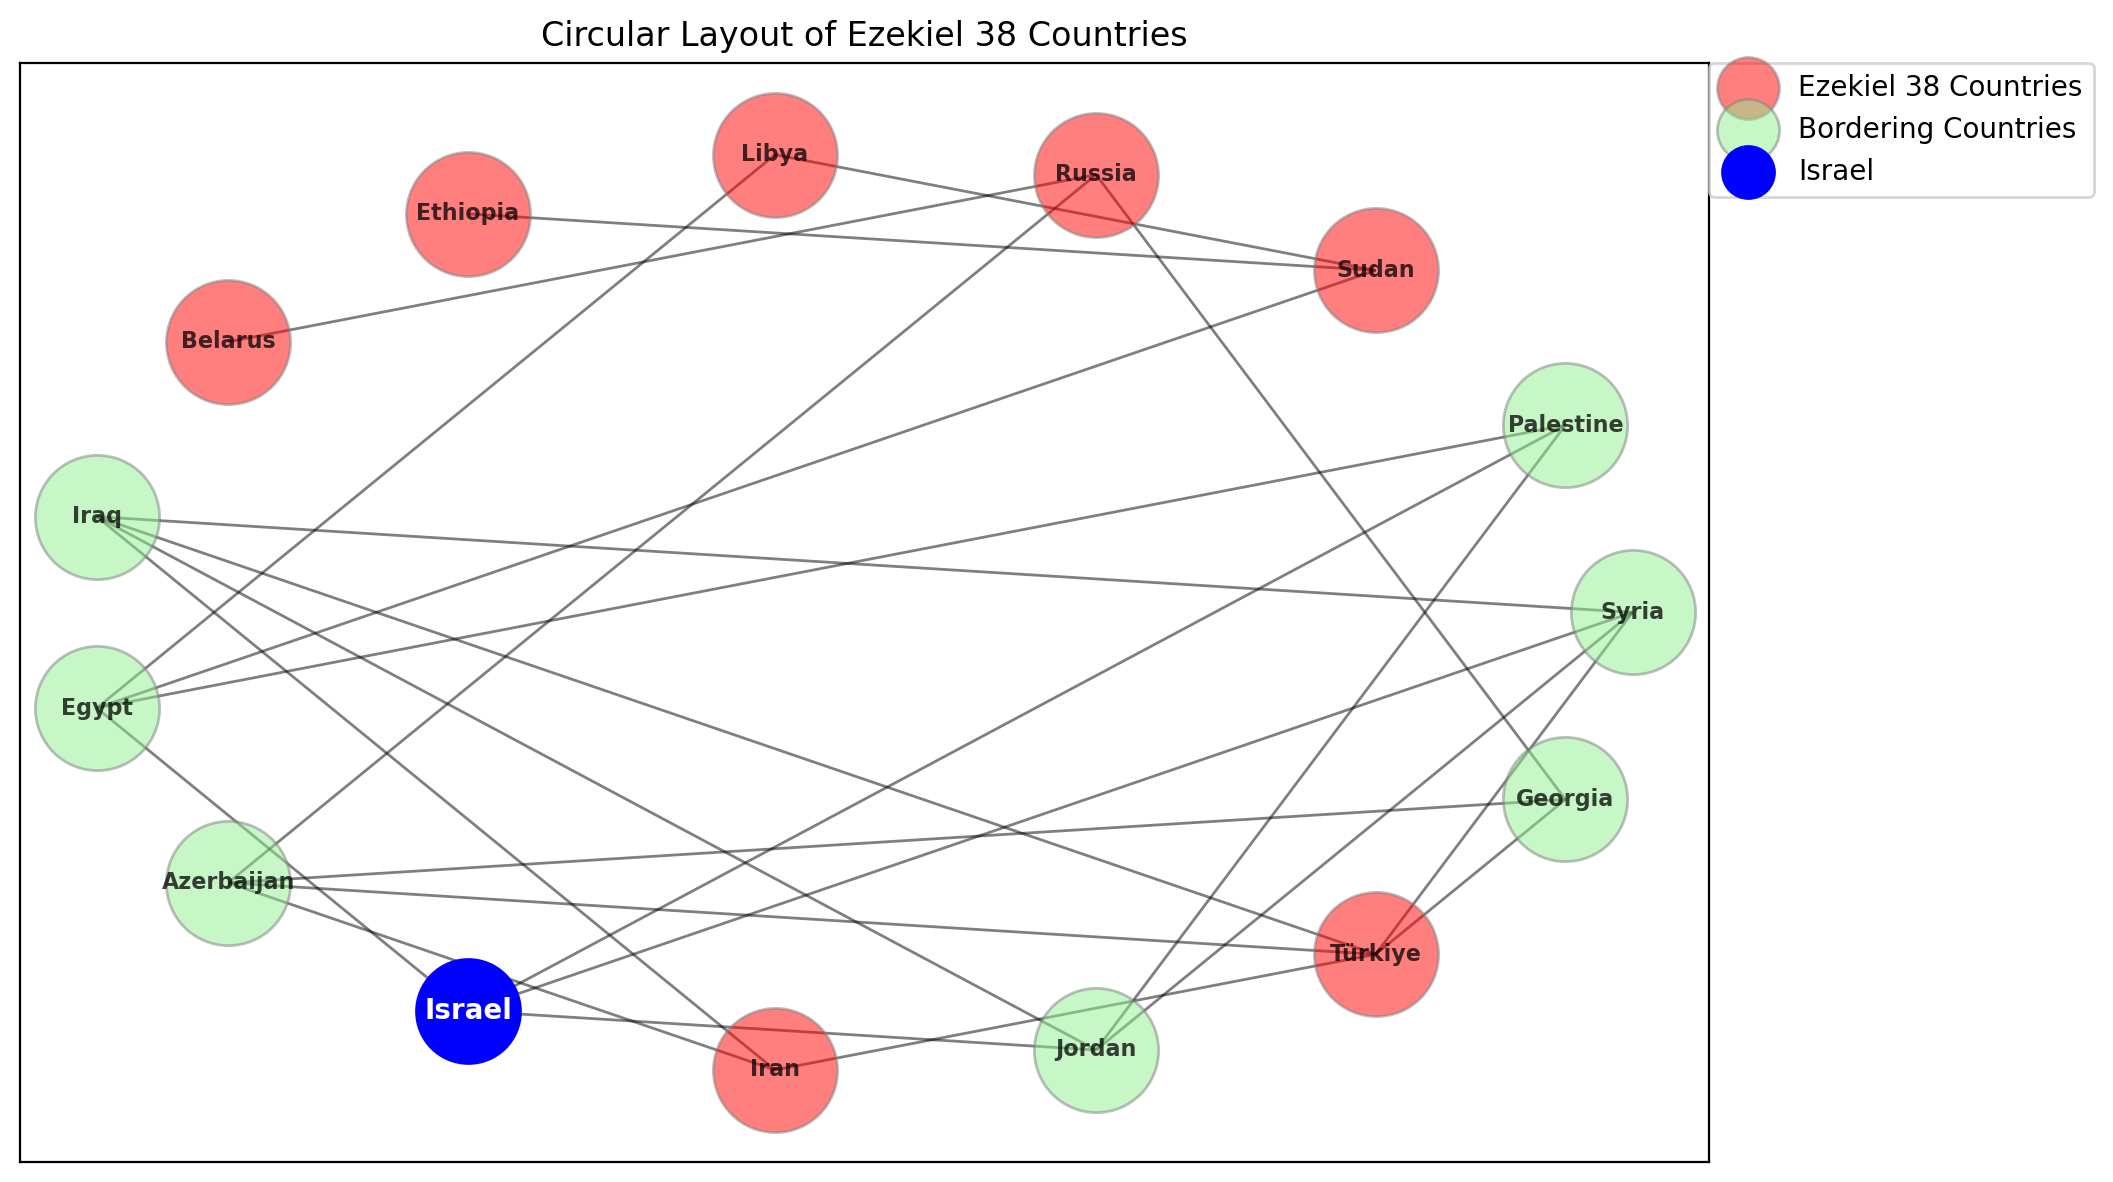

In [60]:

plot_by_layout(ezekiel38_graph, nx.circular_layout(ezekiel38_graph), countries_list=ezekiel38_list, countries_label='Ezekiel 38 Countries', graph_title='Circular Layout of Ezekiel 38 Countries')

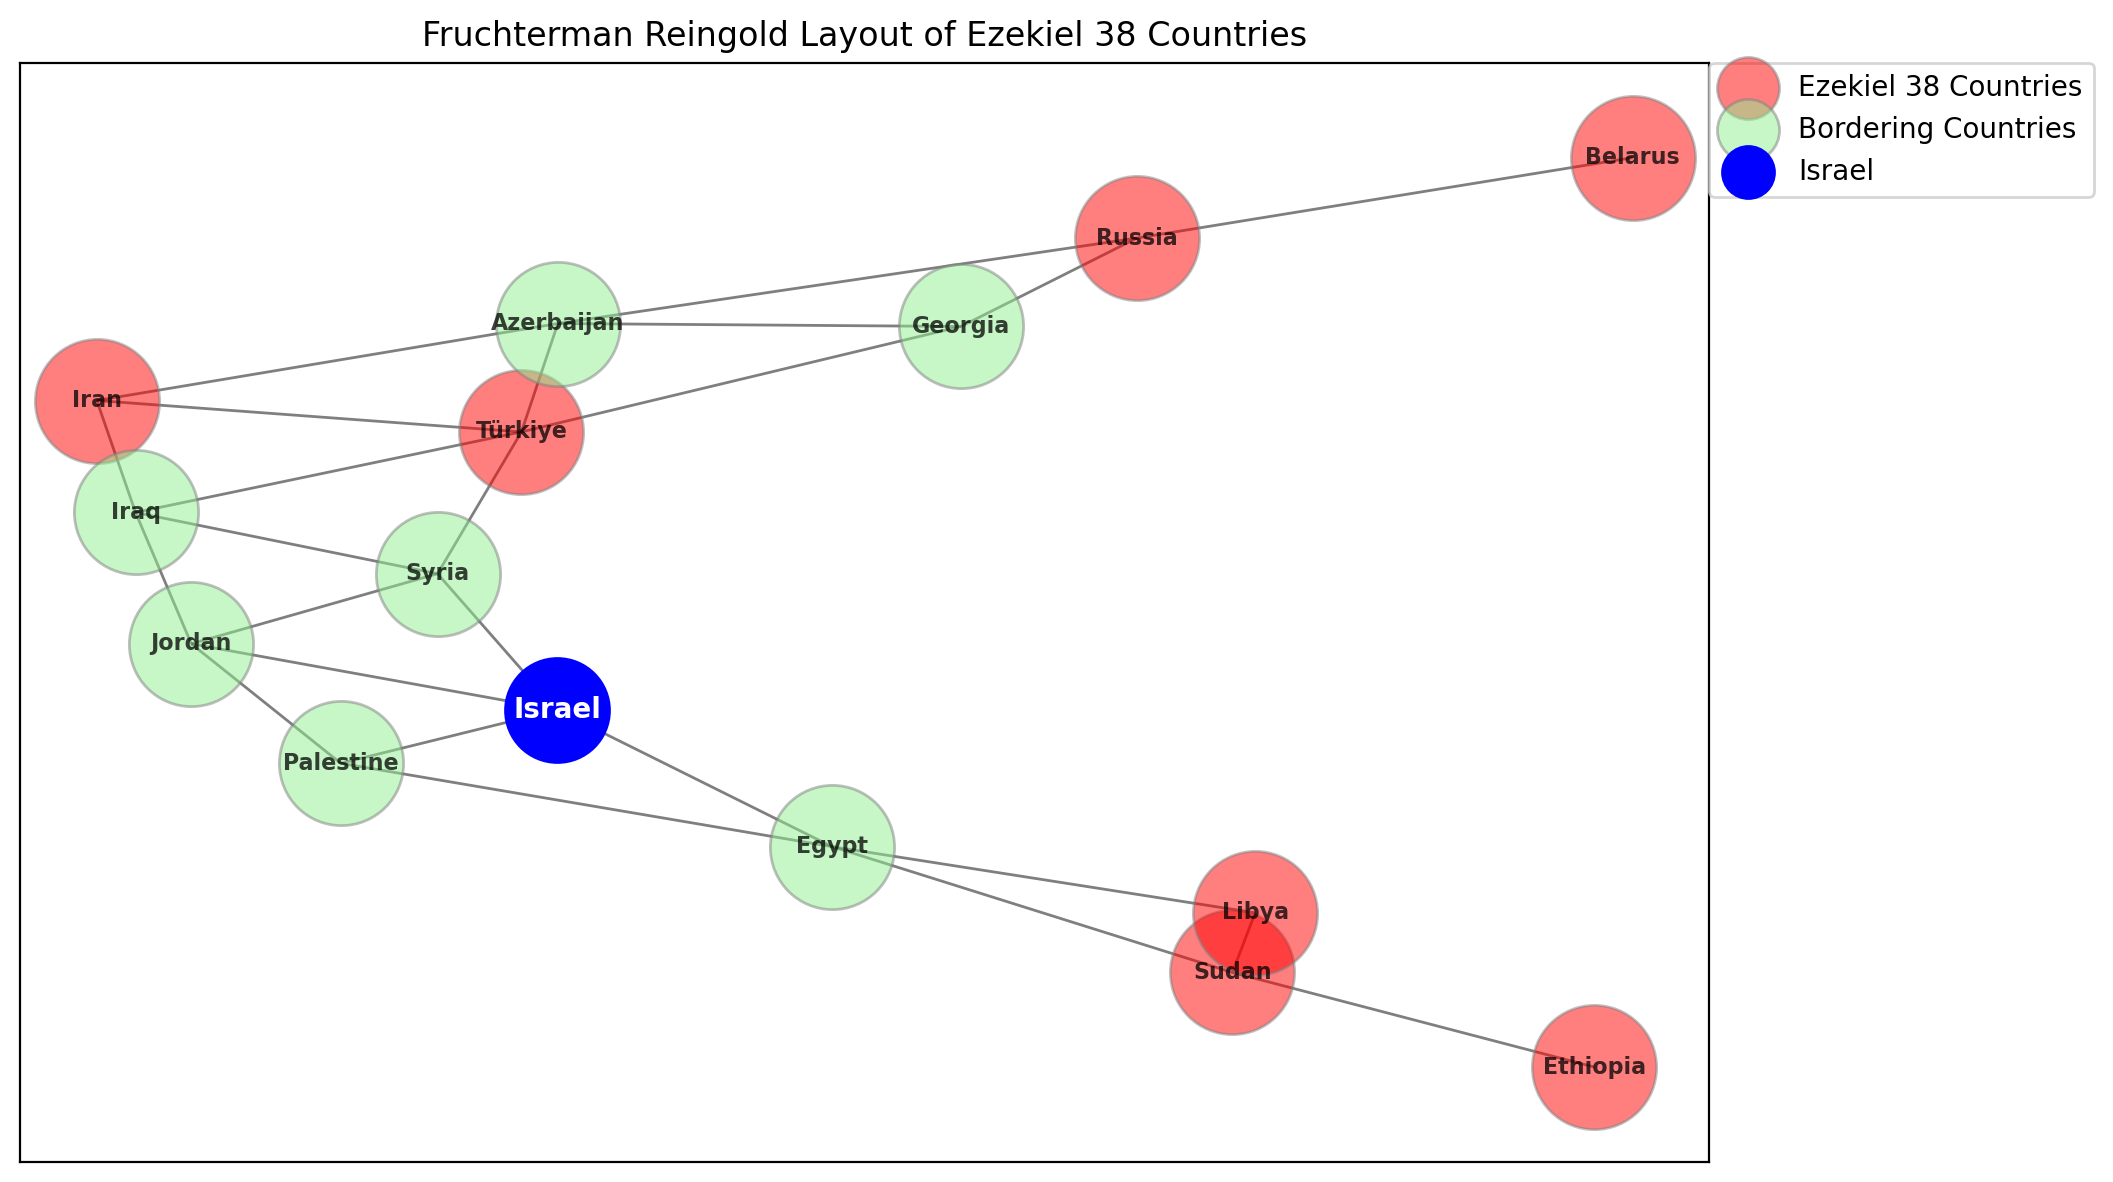

In [61]:

plot_by_layout(
    ezekiel38_graph, nx.fruchterman_reingold_layout(ezekiel38_graph), countries_list=ezekiel38_list, countries_label='Ezekiel 38 Countries', graph_title='Fruchterman Reingold Layout of Ezekiel 38 Countries'
)

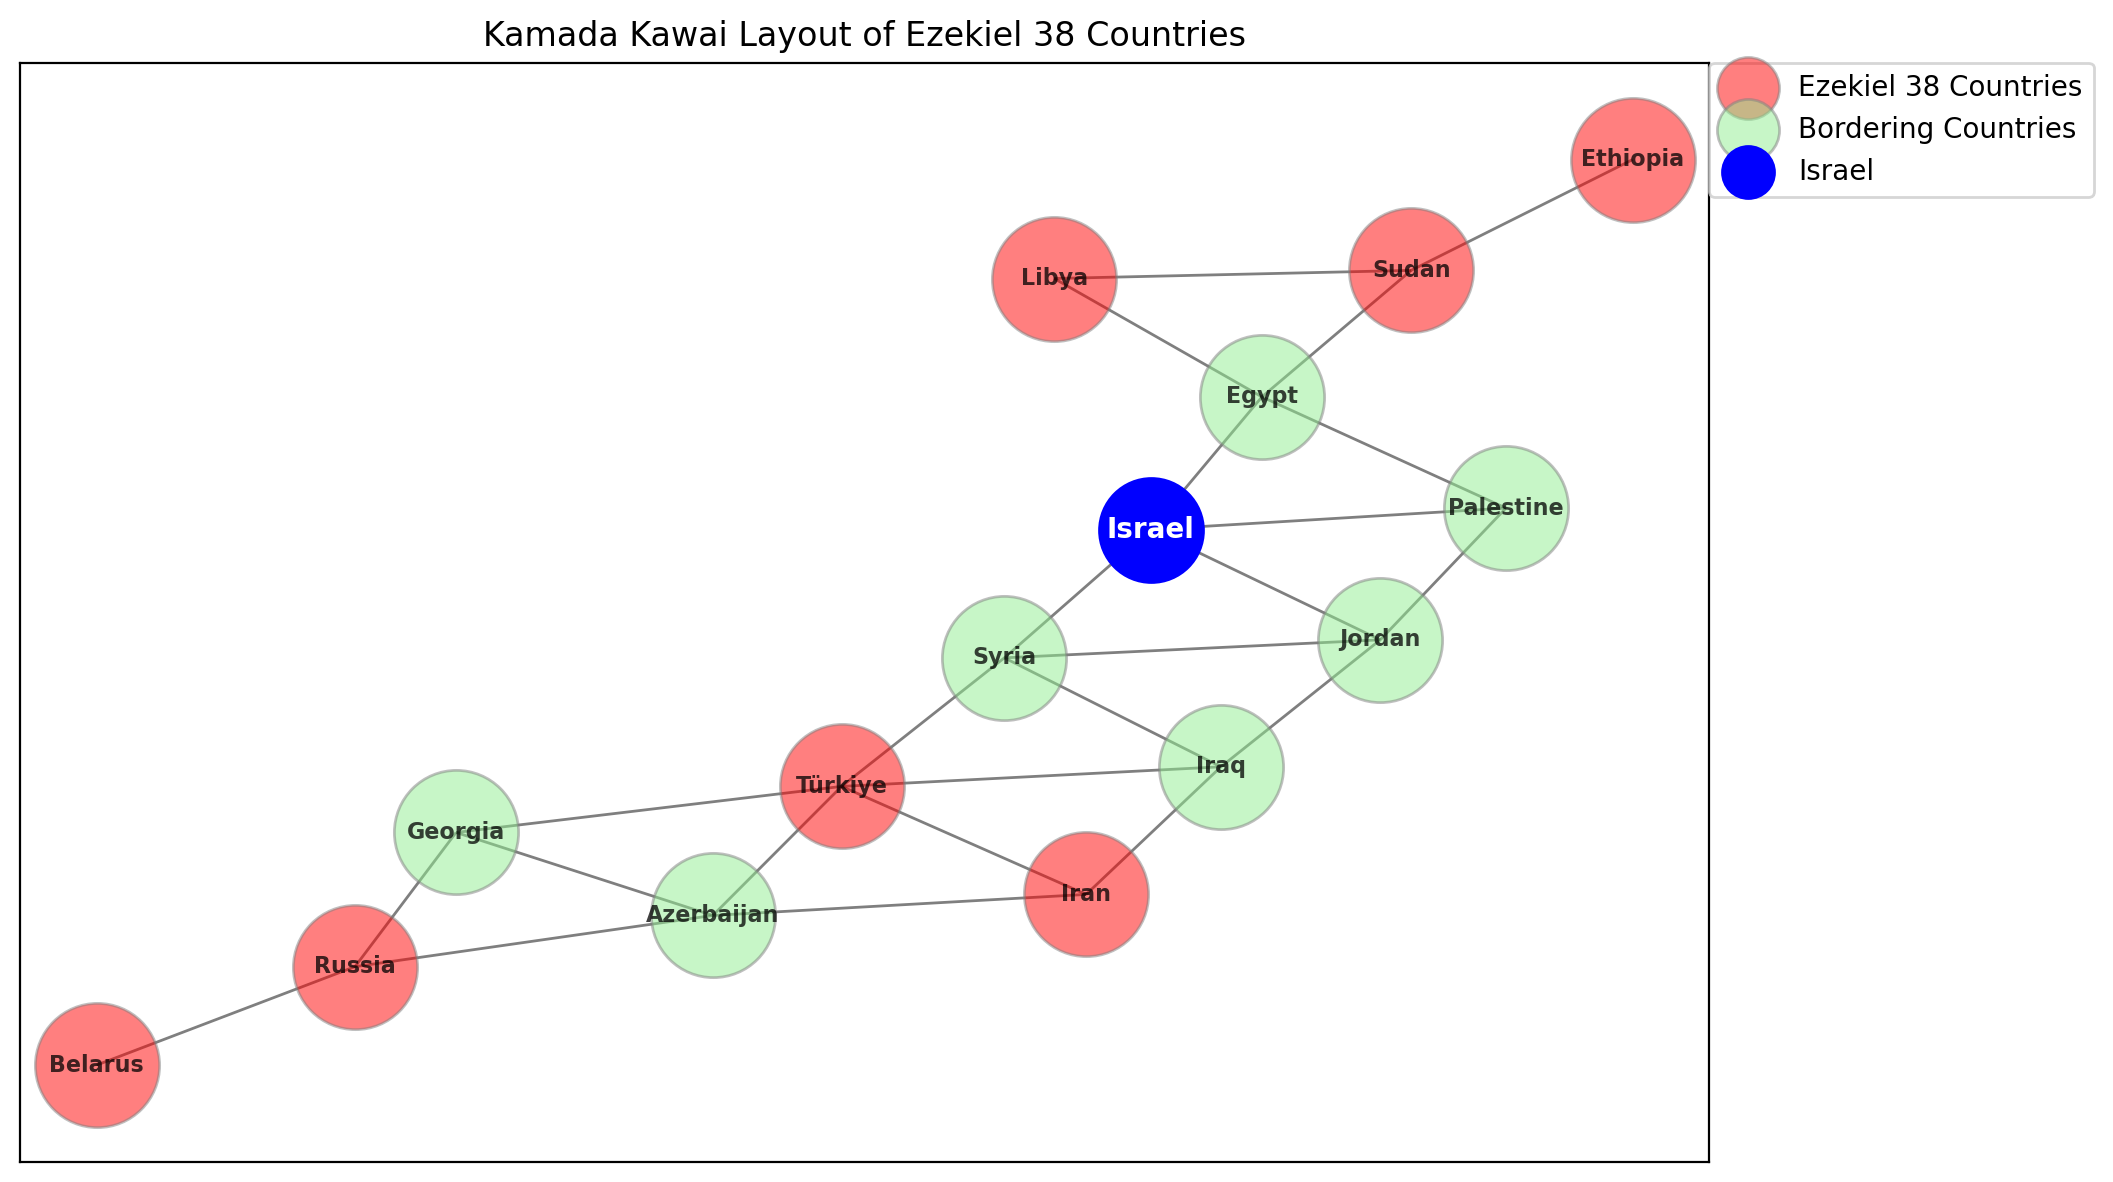

In [62]:

plot_by_layout(ezekiel38_graph, nx.kamada_kawai_layout(ezekiel38_graph), countries_list=ezekiel38_list, countries_label='Ezekiel 38 Countries', graph_title='Kamada Kawai Layout of Ezekiel 38 Countries')

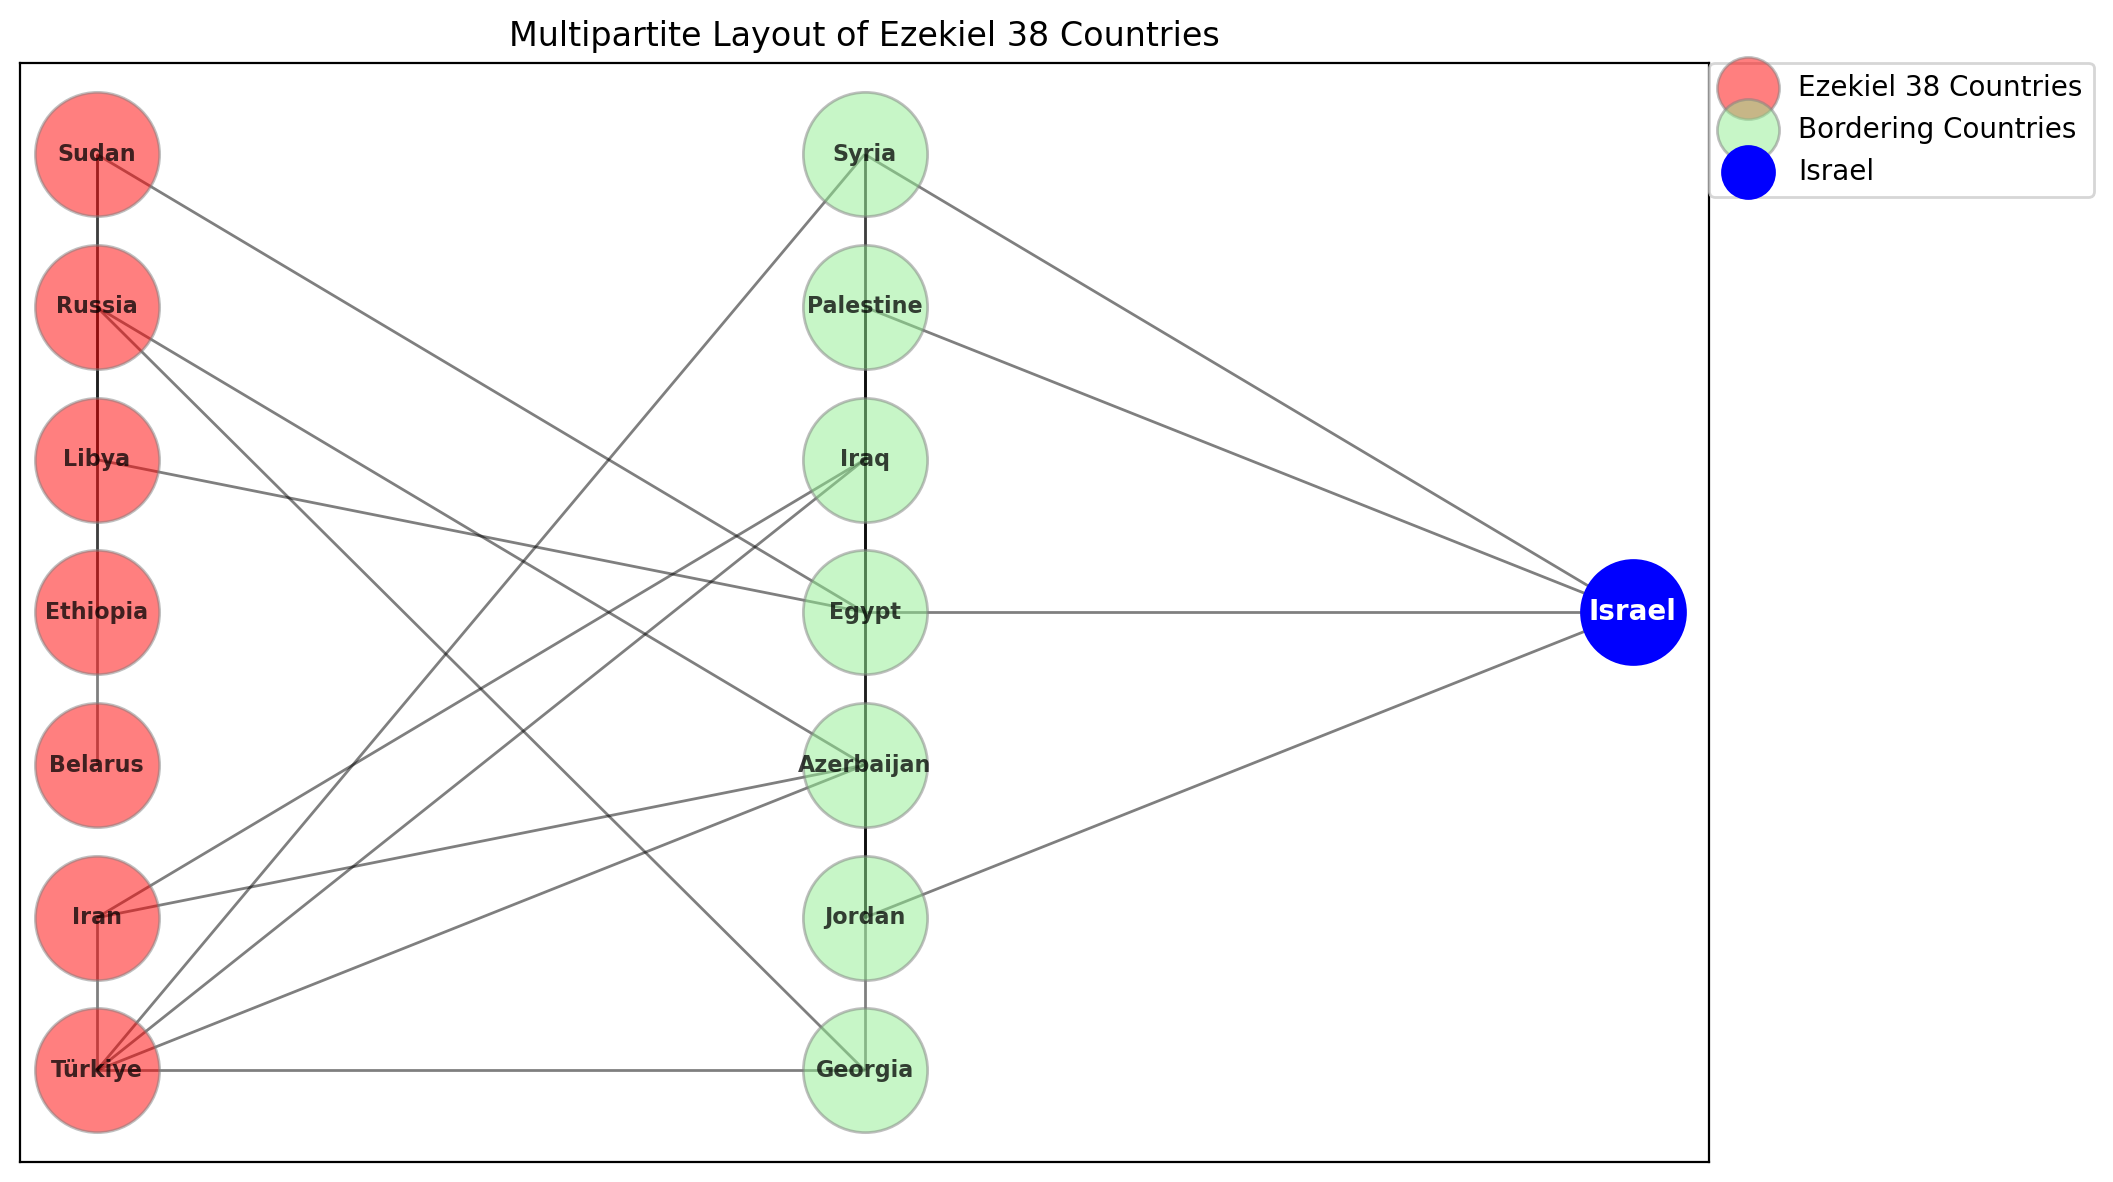

In [63]:

# Set up the subset attributes for multi partite layout
nx.set_node_attributes(ezekiel38_graph, {node: 0 for node in ezekiel38_list if node in ezekiel38_graph.nodes}, 'subset')
mask_series = borders_df.country_name.isin(ezekiel38_list + ['Israel'])
others_list = sorted(borders_df[~mask_series].country_name.unique())
nx.set_node_attributes(ezekiel38_graph, {node: 1 for node in others_list if node in ezekiel38_graph.nodes}, 'subset')
nx.set_node_attributes(ezekiel38_graph, {'Israel': 2}, 'subset')
plot_by_layout(ezekiel38_graph, nx.multipartite_layout(ezekiel38_graph), countries_list=ezekiel38_list, countries_label='Ezekiel 38 Countries', graph_title='Multipartite Layout of Ezekiel 38 Countries')

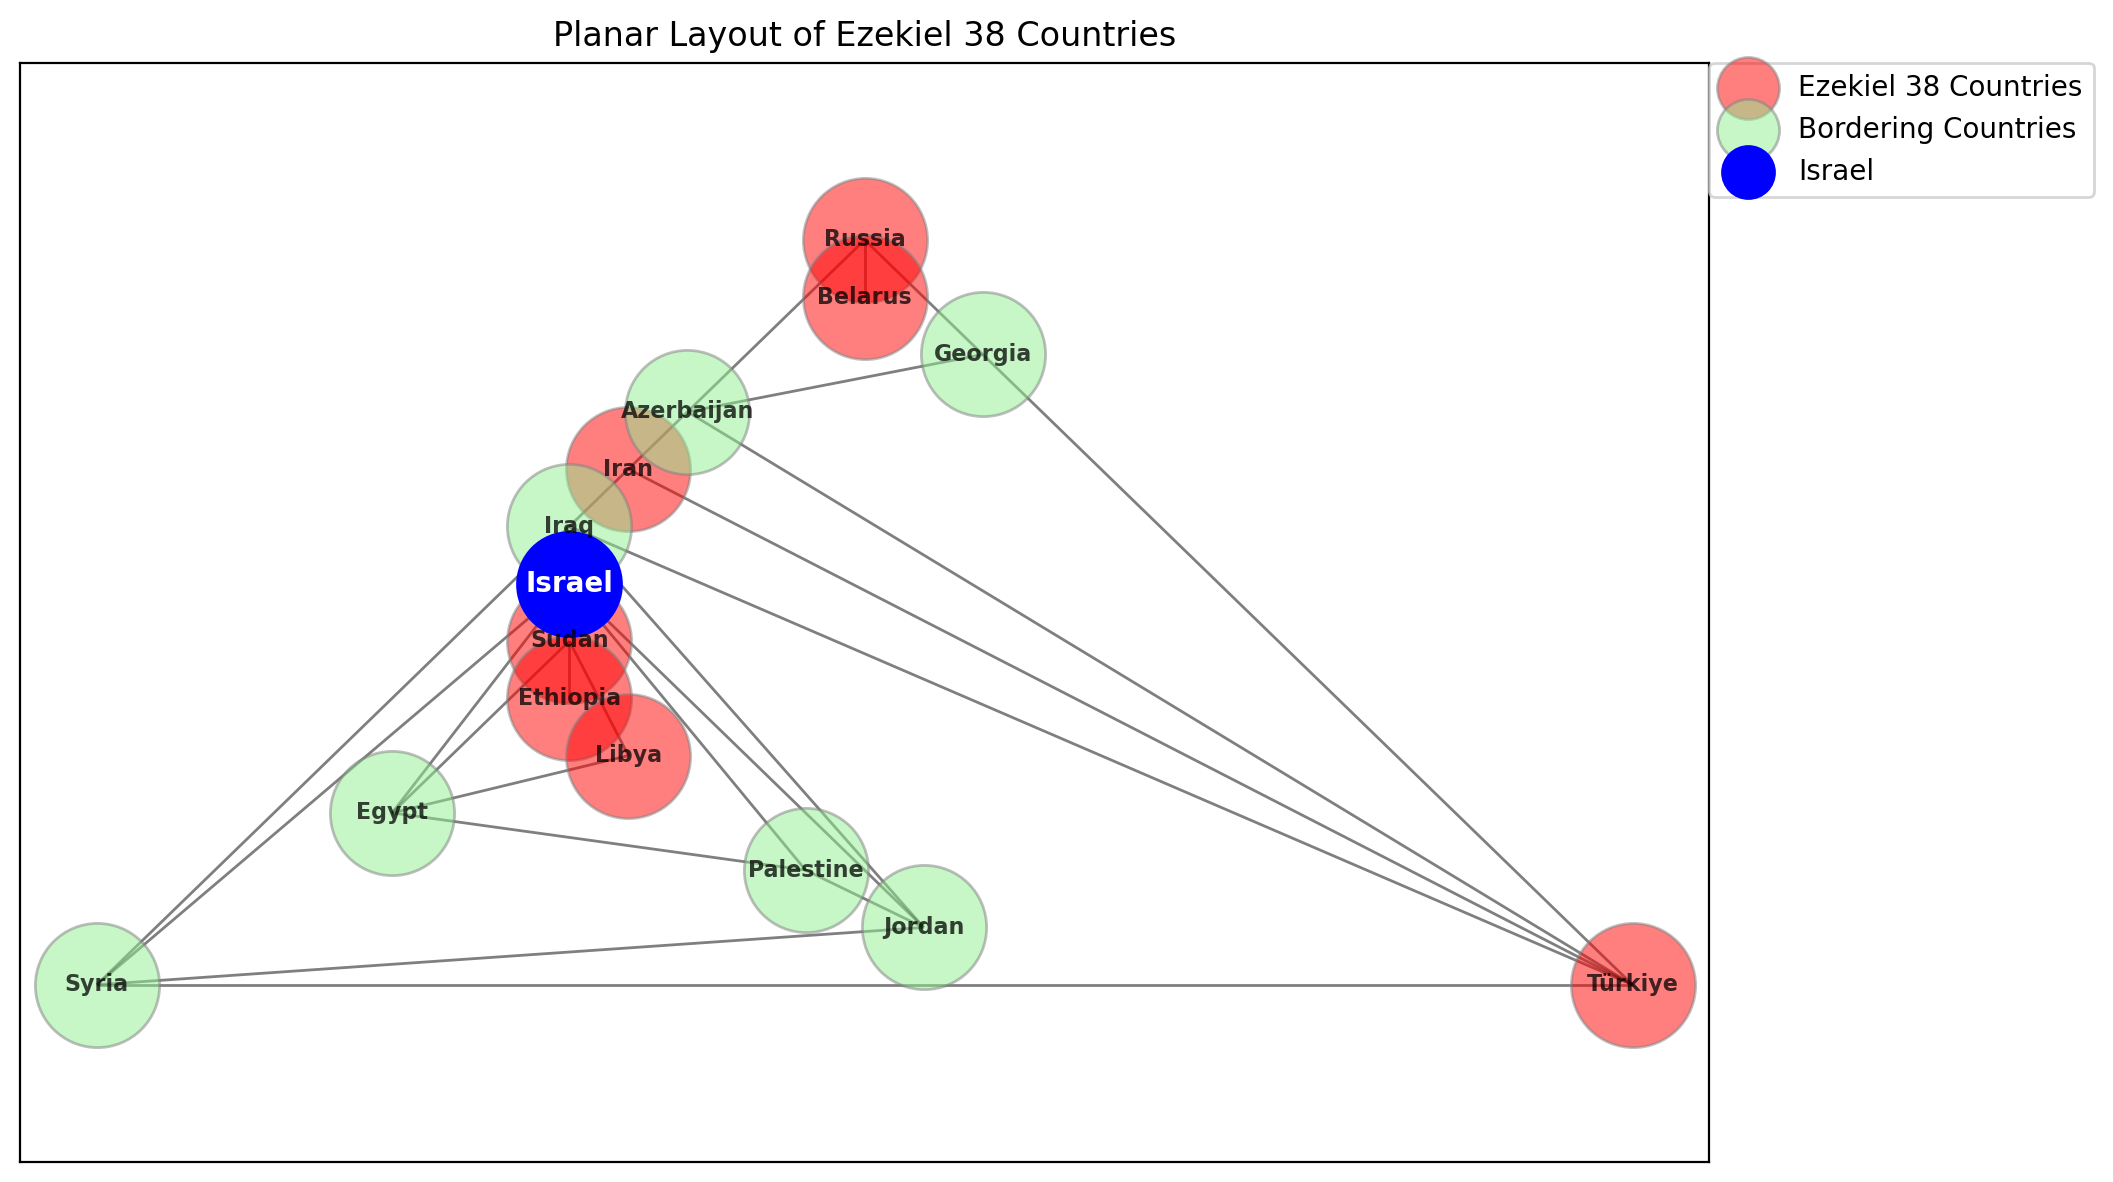

In [64]:

plot_by_layout(ezekiel38_graph, nx.planar_layout(ezekiel38_graph), countries_list=ezekiel38_list, countries_label='Ezekiel 38 Countries', graph_title='Planar Layout of Ezekiel 38 Countries')

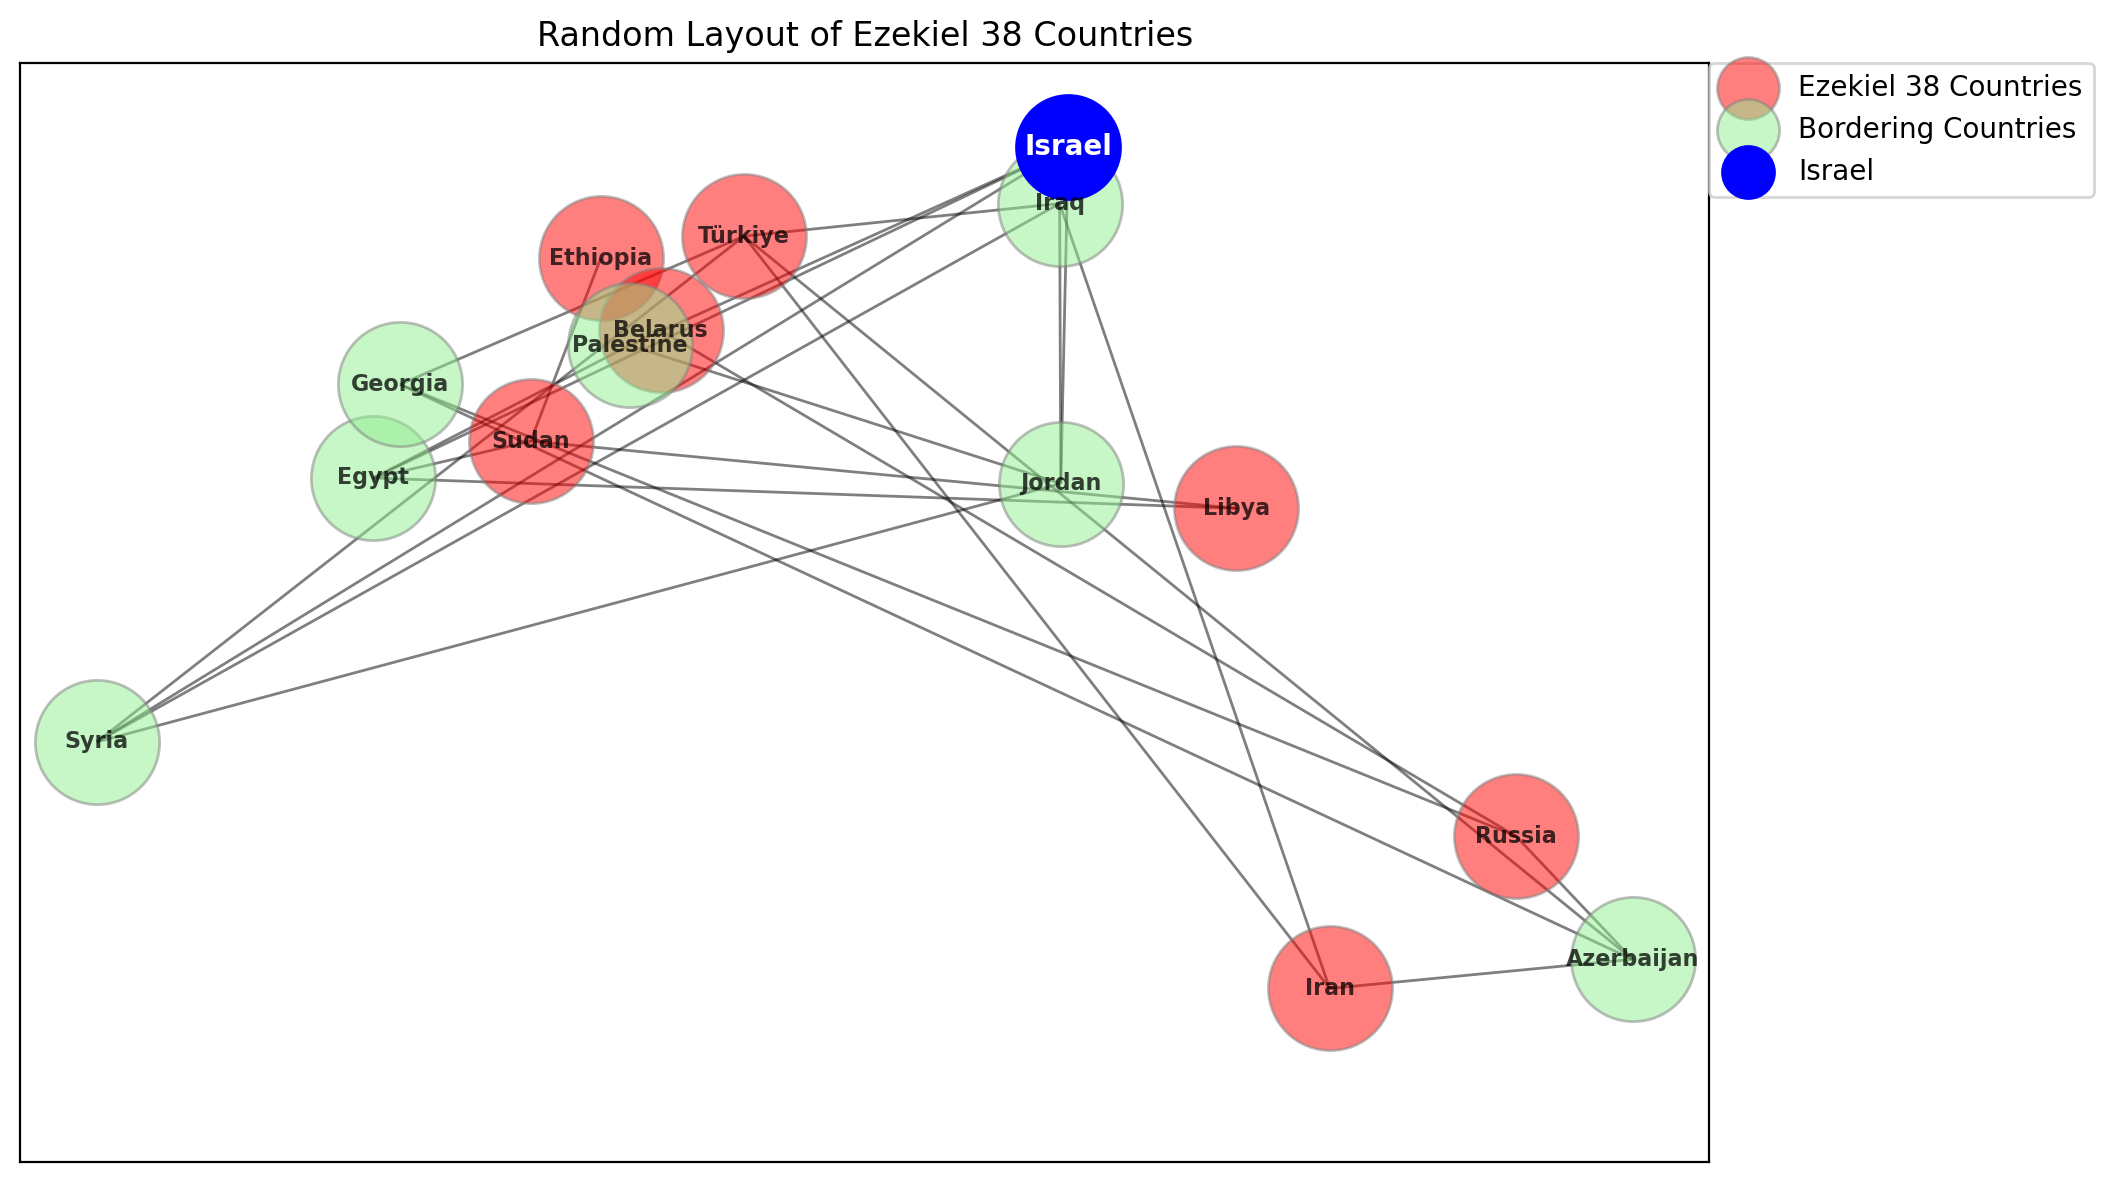

In [65]:

plot_by_layout(ezekiel38_graph, nx.random_layout(ezekiel38_graph), countries_list=ezekiel38_list, countries_label='Ezekiel 38 Countries', graph_title='Random Layout of Ezekiel 38 Countries')

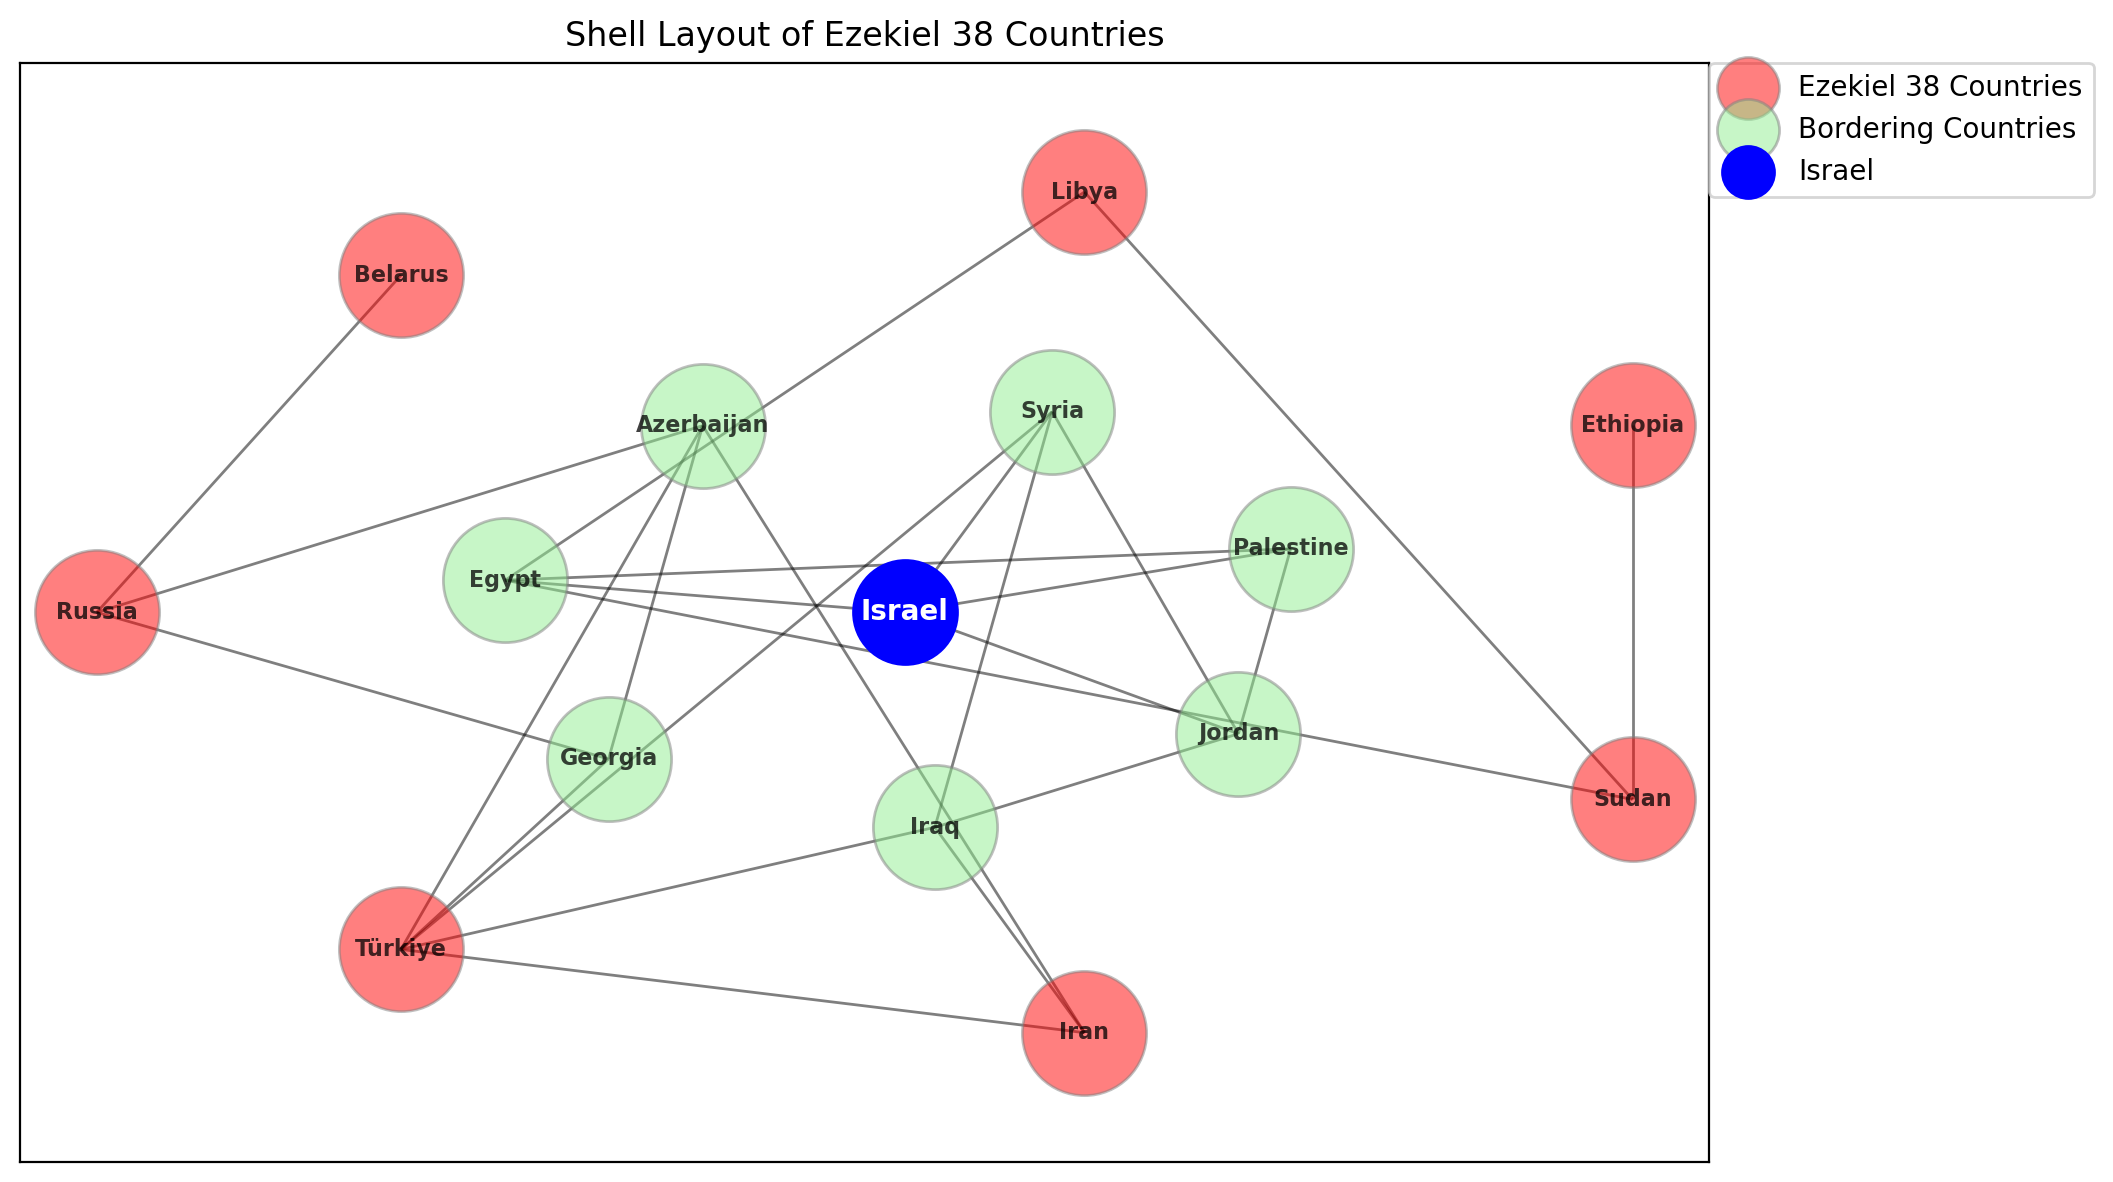

In [66]:

nlist = [['Israel']]
nlist.append(sorted(ezekiel38_countries_set.difference(set(ezekiel38_list + ['Israel']))))
nlist.append(ezekiel38_list)
plot_by_layout(ezekiel38_graph, nx.shell_layout(ezekiel38_graph, nlist=nlist), countries_list=ezekiel38_list, countries_label='Ezekiel 38 Countries', graph_title='Shell Layout of Ezekiel 38 Countries')

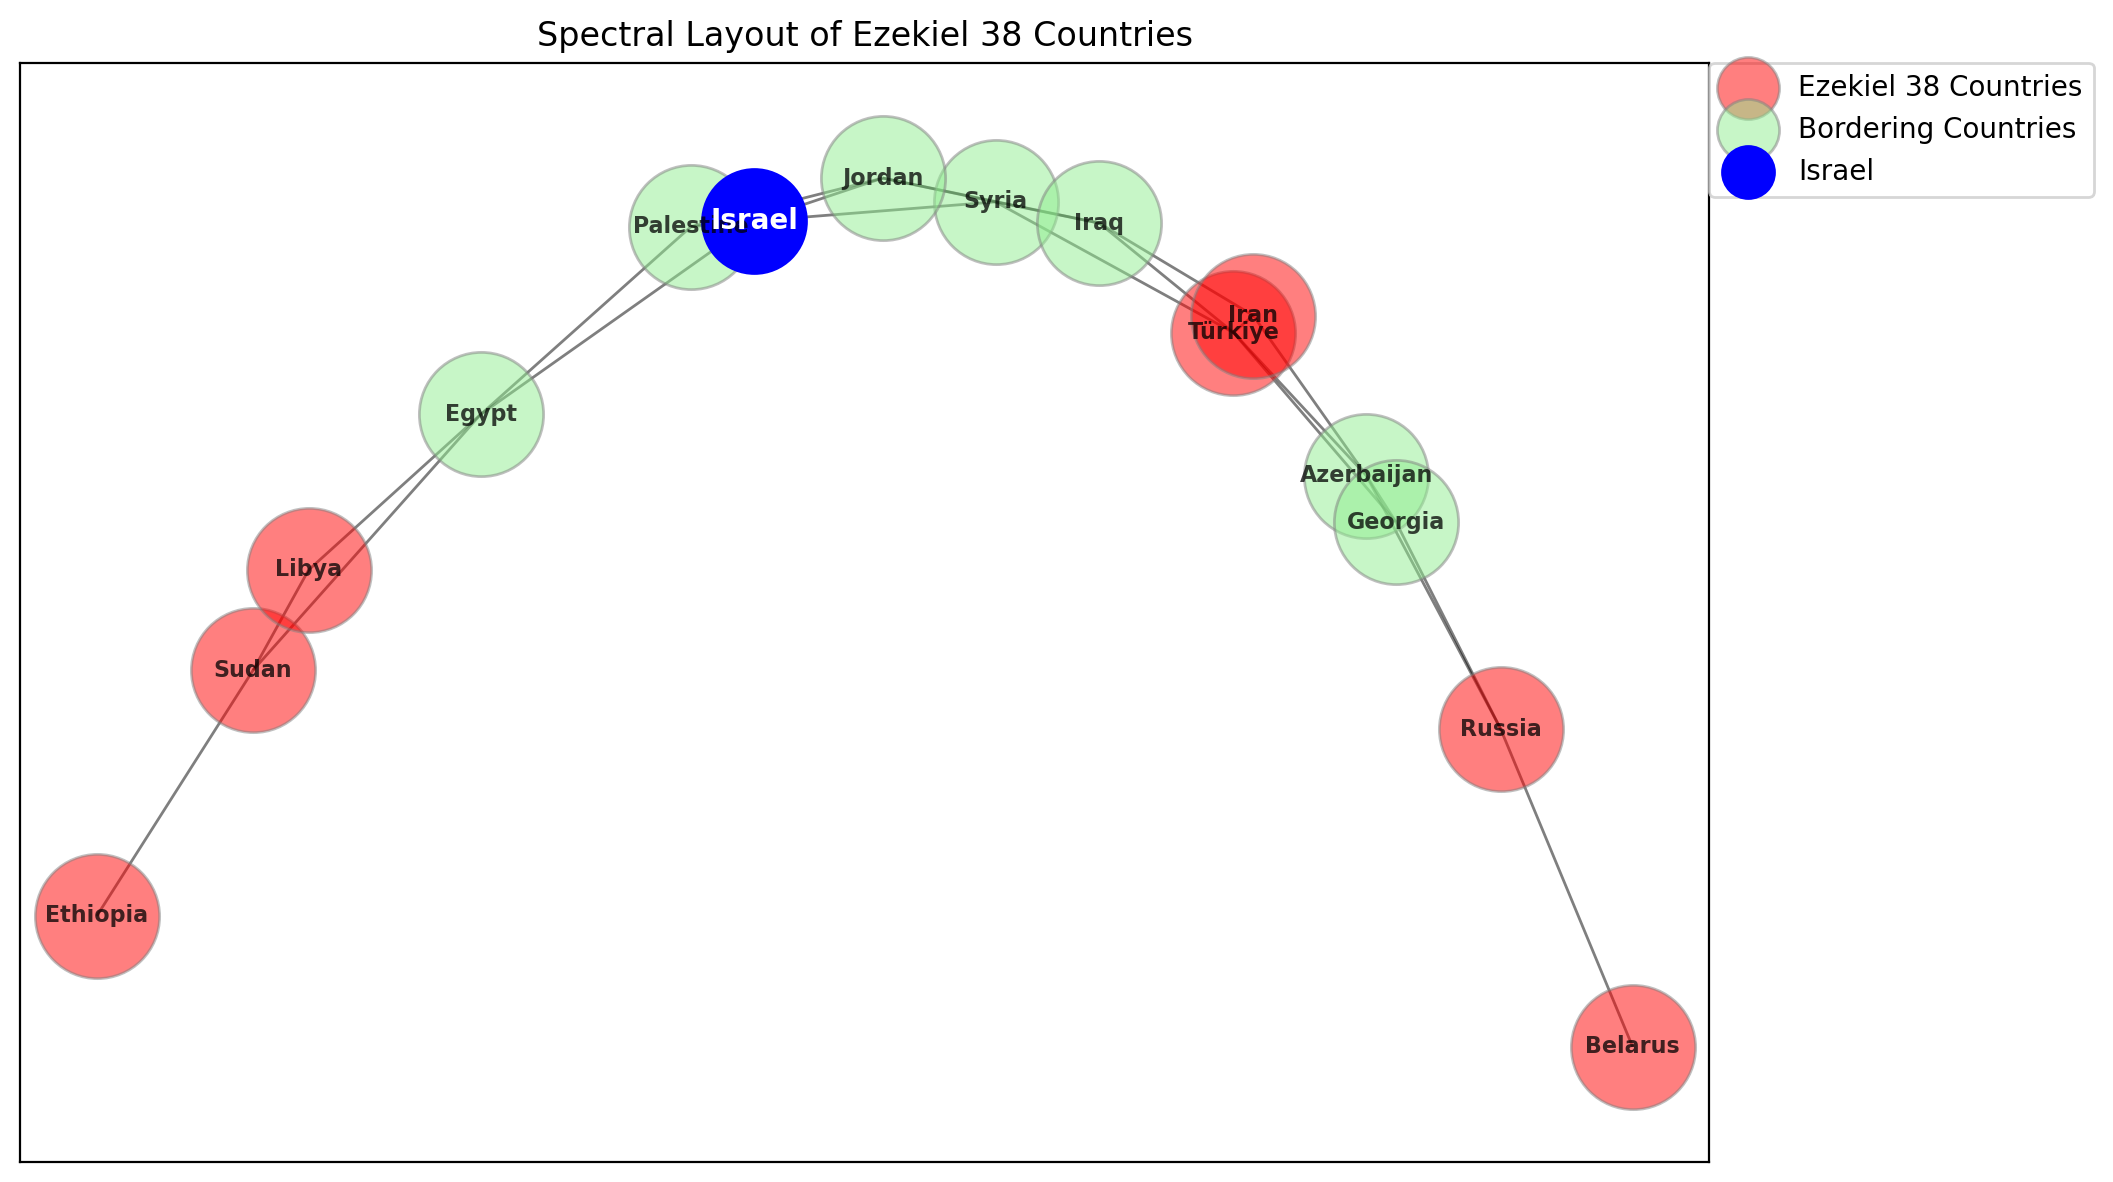

In [81]:

plot_by_layout(
    ezekiel38_graph, nx.spectral_layout(ezekiel38_graph), countries_list=ezekiel38_list, countries_label='Ezekiel 38 Countries', graph_title='Spectral Layout of Ezekiel 38 Countries', verbose=False
)

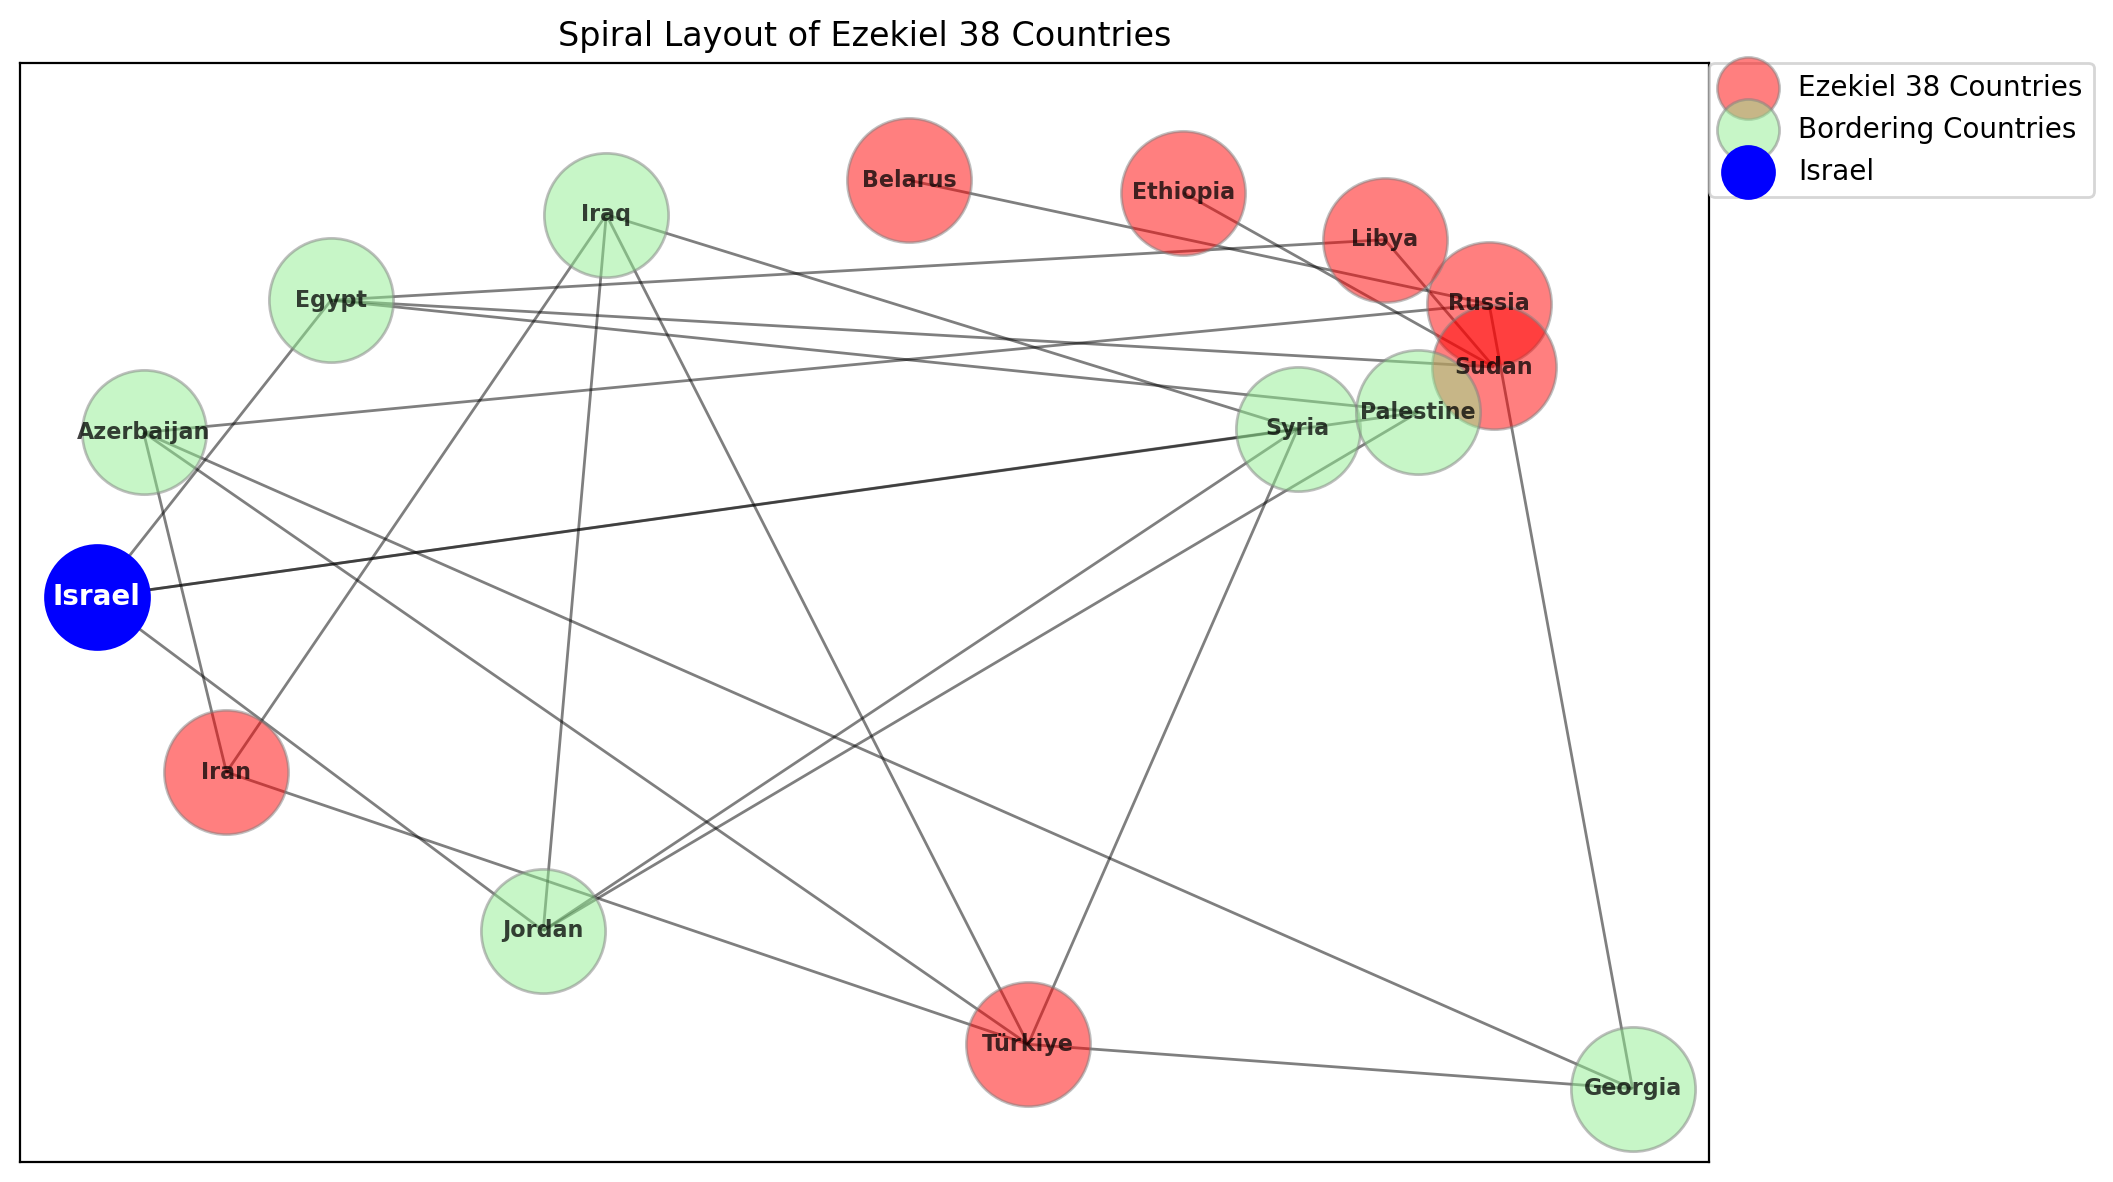

In [68]:

plot_by_layout(ezekiel38_graph, nx.spiral_layout(ezekiel38_graph), countries_list=ezekiel38_list, countries_label='Ezekiel 38 Countries', graph_title='Spiral Layout of Ezekiel 38 Countries')

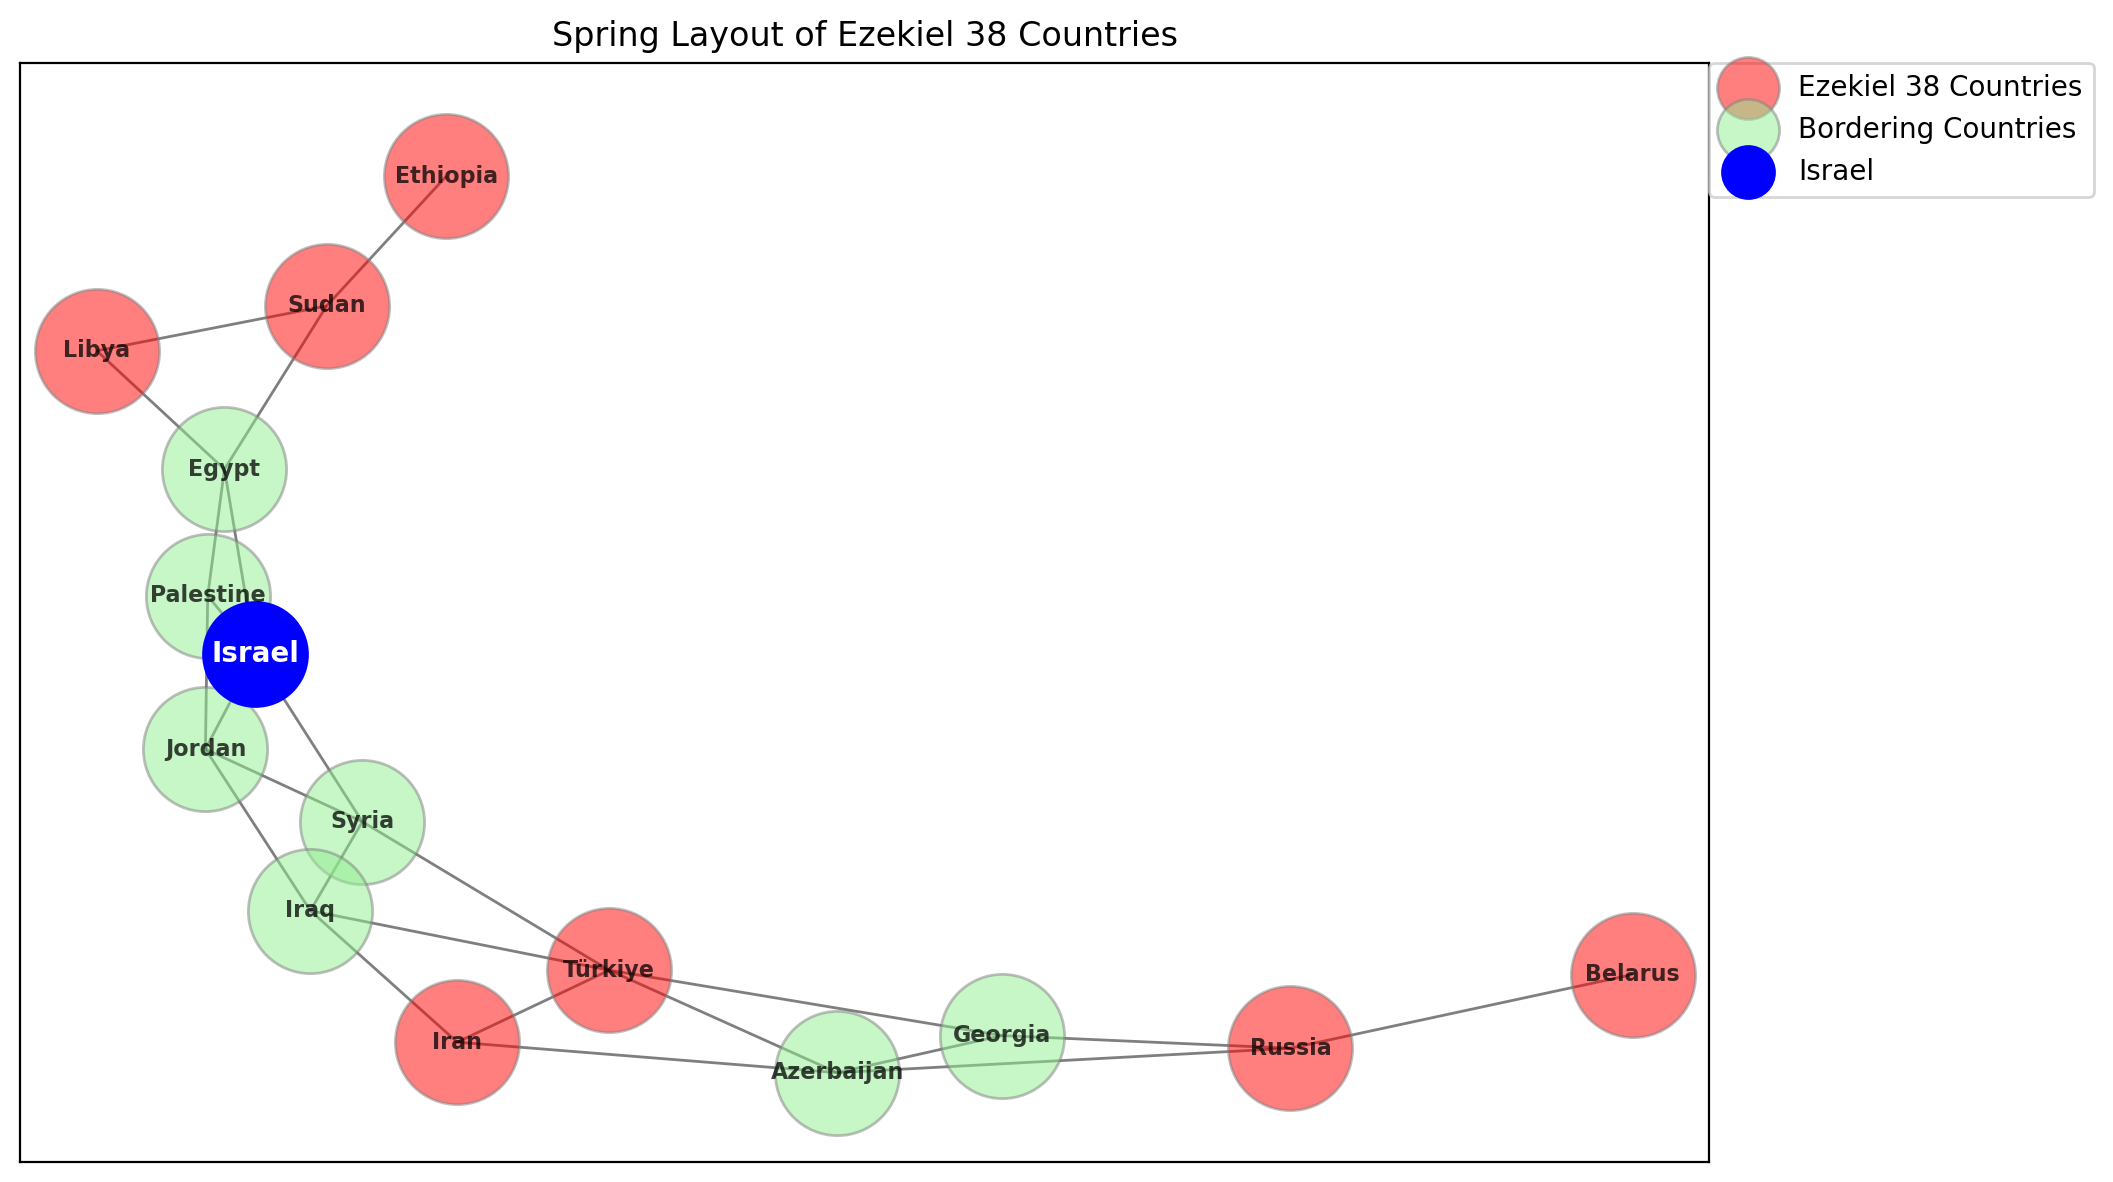

In [69]:

plot_by_layout(ezekiel38_graph, nx.spring_layout(ezekiel38_graph), countries_list=ezekiel38_list, countries_label='Ezekiel 38 Countries', graph_title='Spring Layout of Ezekiel 38 Countries')

In [85]:

pos_dict = {node: pos for node, pos in earth_pos_dict.items() if node in ezekiel38_graph.nodes}
y_values = [pos[1] for node, pos in pos_dict.items()]
padding = 0.2
(min(y_values) - padding, max(y_values) + padding)

(-0.1555555555555555, 0.4944444444444445)

{'Azerbaijan': array([0.48275862, 0.45      ]), 'Belarus': array([0.2137931 , 0.58888889]), 'Egypt': array([0.24137931, 0.3       ]), 'Ethiopia': array([0.35172414, 0.08888889]), 'Georgia': array([0.42758621, 0.46666667]), 'Iran': array([0.55862069, 0.35555556]), 'Iraq': array([0.43448276, 0.36666667]), 'Israel': array([0.30689655, 0.35      ]), 'Jordan': array([0.32413793, 0.34444444]), 'Libya': array([0.06206897, 0.27777778]), 'Palestine': array([0.31310345, 0.35462963]), 'Russia': array([0.30689655, 0.58888889]), 'Sudan': array([0.24137931, 0.16666667]), 'Syria': array([0.35172414, 0.38888889]), 'Türkiye': array([0.31034483, 0.43333333])}
['Russia', 'Türkiye', 'Iran', 'Sudan', 'Ethiopia', 'Libya', 'Belarus']


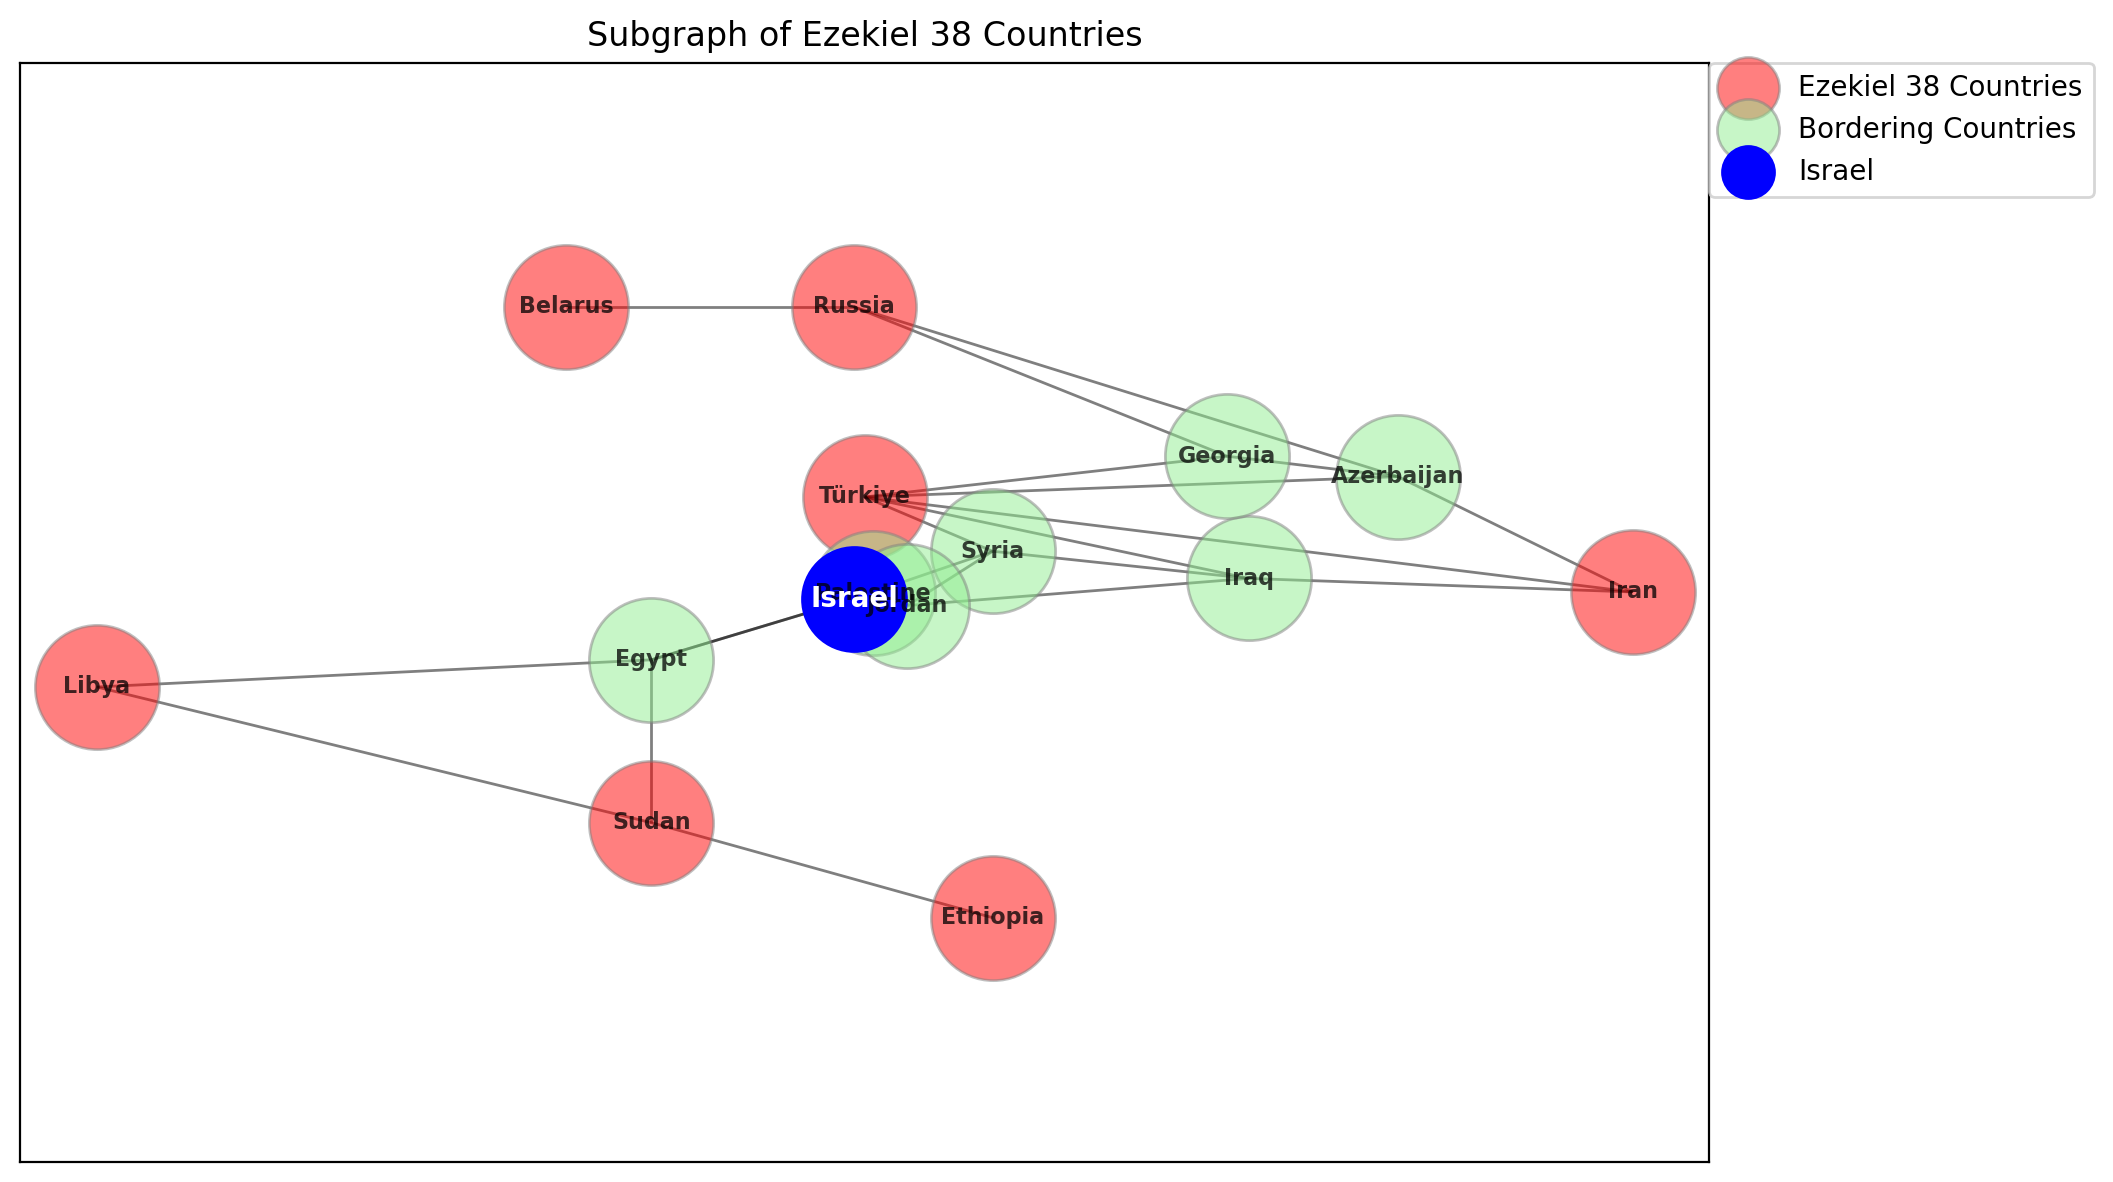

In [88]:

earth_pos_dict['Russia'] = np.array([earth_pos_dict['Israel'][0], earth_pos_dict['Belarus'][1]])
plot_by_layout(
    ezekiel38_graph, {node: pos for node, pos in earth_pos_dict.items() if node in ezekiel38_graph.nodes}, countries_list=ezekiel38_list, countries_label='Ezekiel 38 Countries',
    graph_title='Subgraph of Ezekiel 38 Countries', verbose=True
)


----
# Maintenance

In [ ]:

# Check how the graph is connected
if not nx.is_connected(ALL_COUNTRIES_GRAPH):
    continents_list = sorted([c for c in nx.connected_components(ALL_COUNTRIES_GRAPH) if len(c) > 1], key=lambda x: len(x))
    for connected_countries in continents_list:
        print(connected_countries)
    plot_by_layout(ALL_COUNTRIES_GRAPH.subgraph(continents_list[-1]), earth_pos_dict, graph_title='Earth as a Nodes-and-Edges Graph')

In [10]:

pyperclip.copy(f"""Make a python dictionary called centroids_dict of the centroid of each of these countries: {nu.conjunctify_nouns(sorted(continents_list[0]))}. Make the keys the country names and the values in decimal tuples (i.e., convert those "° N" and "° E" to negative or positive floats.)""")

In [29]:

pyperclip.copy(f"""Make a python dictionary called pos_dict of the centroid of each of these countries: {nu.conjunctify_nouns(sorted(psalm83_countries_set))}. Make the keys the country names and the values in decimal tuples (i.e., convert those "° N" and "° E" to negative or positive floats.)""")

In [31]:

pos_dict = {
    'Algeria': np.array([28.0339, 1.6596]),
    'Azerbaijan': np.array([40.1431, 47.5769]),
    'Belarus': np.array([53.5285, 28.0444]),
    'Egypt': (26.8206, 30.8025),
    'Ethiopia': np.array([9.1450, 40.4897]),
    'France': np.array([46.6034, 1.8883]),
    'Georgia': np.array([42.3154, 43.3569]),
    'Germany': np.array([51.1657, 10.4515]),
    'Iran': np.array([32.4279, 53.6880]),
    'Iraq': (33.1128, 43.8938),
    'Israel': (31.0461, 34.8516),
    'Jordan': (30.5852, 36.2384),
    'Lebanon': (33.8547, 35.8623),
    'Libya': np.array([26.3351, 17.2283]),
    'Morocco': np.array([31.7917, -7.0926]),
    'Palestine': (31.9522, 35.2332),
    'Poland': np.array([51.9194, 19.1451]),
    'Russia': np.array([53.5285, 34.8516]), # Placed due north of Israel and due east of Belarus
    'Saudi Arabia': (23.8859, 45.0792),
    'Spain': np.array([40.4637, -3.7492]),
    'Sudan': np.array([12.8628, 30.2176]),
    'Syria': (34.8021, 38.9968),
    'Türkiye': np.array([38.9637, 35.2433]),
}

In [40]:

pyperclip.copy(f"""If you had a latlon that barely contained each of these countries ({nu.conjunctify_nouns(sorted(psalm83_countries_set))}), what would be the latlon of the Left Top (Northwest), Right Top (Northeast), Left Bottom (Southwest), and Right Bottom (Southeast) of the map? Give the answer in a python dictionary called corners_dict with the keys being "Left Bottom (Southwest)", "Left Top (Northwest)", "Right Bottom (Southeast)", and "Right Top (Northeast)" and the values being decimal tuples (i.e., convert those "° N" and "° E" to negative or positive floats.)""")

In [ ]:

# Replace corrrectable country names with official names
countries_dict = {
    "Cape Verde": "Cabo Verde",
    "Democratic Republic of the Congo": "Congo, Democratic Republic of the",
    "East Timor": "Timor-Leste",
    "Federated States of Micronesia": "Micronesia (Federated States of)",
    "Macau": "Macao",
    "Netherlands": "Netherlands, Kingdom of the",
    # "Palestine": "Palestine, State of",
    "São Tomé and Príncipe": "Sao Tome and Principe",
    "Turkey": "Türkiye",
    "United Kingdom": "United Kingdom of Great Britain and Northern Ireland",
    "United States": "United States of America",
    "Vatican City": "Holy See",
    "Vietnam": "Viet Nam"
}
for correctable_name, official_name in countries_dict.items():
    mask_series = (borders_df.country_name == correctable_name); borders_df.loc[mask_series, 'country_name'] = official_name

In [ ]:

# Replace corrrectable names in the neighbors lists with official names
def update_neighbors(row):
    neighbors_list = row['neighbors_list']
    if neighbors_list:
        return sorted(set([countries_dict.get(x, x) for x in neighbors_list]))
    return []

borders_df['neighbors_list'] = borders_df.apply(update_neighbors, axis=1)

In [ ]:

        try:
        except Exception as e:
            message = str(e).strip()
            print(f"{e.__class__.__name__} error in predict_percent_fit: {message}")

In [ ]:

pyperclip.copy(r'\b(' + '|'.join(borders_df.country_name.unique()) + r')\b')

In [ ]:

print([f'nu.{fn}' for fn in dir(nu) if 'table' in fn])
print([f'nu.{fn}' for fn in dir(nu) if 'soup' in fn])
print([f'nu.{fn}' for fn in dir(nu) if 'typo' in fn])

In [ ]:

nx.spiral_layout?

In [ ]:

print([f'nx.{fn}' for fn in dir(nx) if 'layout' in fn.lower()])


## Check the countries in the neighbors list cleanup

In [ ]:

mask_series = borders_df.country_name.map(lambda x: bool(re.search("Fr(anc|ench)", str(x))))
borders_df[mask_series]

In [ ]:

mask_series = borders_df.country_name.map(lambda x: bool(re.search("(Palestin|Gaza|Occupied|Samaria)", str(x))))
borders_df[mask_series]

In [ ]:

mask_series = borders_df.country_name.map(lambda x: bool(re.search("Netherlands", str(x))))
borders_df[mask_series]

In [ ]:

mask_series = borders_df.country_name.map(lambda x: bool(re.search("Denmark", str(x))))
borders_df[mask_series]


## Check before and after standardizing the neighbors lists

In [ ]:

mask_series = borders_df.country_name.map(lambda x: bool(re.search("Angola", str(x))))
borders_df[mask_series]

In [ ]:

mask_series = borders_df.country_name.map(lambda x: bool(re.search("Armenia", str(x))))
borders_df[mask_series]

In [ ]:

mask_series = borders_df.country_name.map(lambda x: bool(re.search("Angola", str(x))))
borders_df[mask_series]

In [ ]:

mask_series = borders_df.country_name.map(lambda x: bool(re.search("Armenia", str(x))))
borders_df[mask_series]

In [ ]:

max(-0.61826711,  0.86578615, -0.82103335, 0.57351431)

In [ ]:

from numpy import array

G = nx.Graph()
G.add_nodes_from(['Left Top (Northwest)', 'Right Top (Northeast)', 'Left Bottom (Southwest)', 'Right Bottom (Southeast)'])
left = -1.
bottom = -1.
top = 1.
right = 1.
pos_dict = {
    'Left Top (Northwest)': array([left, top]),
    'Right Top (Northeast)': array([right, top]),
    'Left Bottom (Southwest)': array([left, bottom]),
    'Right Bottom (Southeast)': array([right, bottom])
}
plt.figure(figsize=(10, 8))
nx.draw(G, pos=pos_dict, with_labels=True, node_size=2000, node_color='lightgreen', font_size=10, font_weight='bold', edge_color='gray')
plt.title('Test Graph')
plt.show()

In [ ]:

pos_dict = nx.spring_layout(G)
pos_dict

In [ ]:

print([f'nx.{fn}' for fn in dir(nx) if not fn.startswith('_')])

In [ ]:

print(source, target)
print(list(nx.shortest_simple_paths(ALL_COUNTRIES_GRAPH, source, target)))
for countries_list in generator_obj:
    print(countries_list)

In [ ]:

nx.single_target_shortest_path_length?

In [ ]:

t1 = time.time()
print(list(nx.shortest_simple_paths(ALL_COUNTRIES_GRAPH, source, target)))
speech_str = f'shortest_simple_paths completed in {time.time() - t1}'; print(speech_str)

In [ ]:

t1 = time.time()
print(list(nx.shortest_path_length(ALL_COUNTRIES_GRAPH, source, target)))
speech_str = f'shortest_path_length completed in {time.time() - t1}'; print(speech_str)

In [ ]:

t1 = time.time()
print(list(nx.shortest_path(ALL_COUNTRIES_GRAPH, source, target)))
speech_str = f'all_shortest_paths completed in {time.time() - t1}'; print(speech_str)

In [ ]:

t1 = time.time()
print(list(nx.all_shortest_paths(ALL_COUNTRIES_GRAPH, source, target)))
speech_str = f'all_shortest_paths completed in {time.time() - t1}'; print(speech_str)

In [ ]:

print([f'nx.{fn}' for fn in dir(nx) if not fn.startswith('_')])
print([f'ALL_COUNTRIES_GRAPH.{fn}' for fn in dir(ALL_COUNTRIES_GRAPH) if 'shortest' in fn.lower()])

In [ ]:

official_list = sorted(ssu.alpha3_to_country_dict.values())
correctable_list = sorted(borders_df.country_name)
df = nu.check_for_typos(official_list, correctable_list, rename_dict={'left_item': 'official_name', 'right_item': 'correctable_name'})
mask_series = (df.max_similarity < 1.0)
for row_index, row_series in df[mask_series].sort_values('max_similarity', ascending=False).iterrows():
    correctable_name = row_series.correctable_name
    official_name = row_series.official_name
    print(f'''
mask_series = (borders_df.country_name == "{correctable_name}"); borders_df.loc[mask_series, 'country_name'] = "{official_name}"''')

In [ ]:

df = nu.check_for_typos(correctable_list, official_list, rename_dict={'left_item': 'correctable_name', 'right_item': 'official_name'})
mask_series = (df.max_similarity < 1.0)
for row_index, row_series in df[mask_series].sort_values('max_similarity', ascending=False).iterrows():
    correctable_name = row_series.correctable_name
    official_name = row_series.official_name
    print(f'''
mask_series = (borders_df.country_name == "{correctable_name}"); borders_df.loc[mask_series, 'country_name'] = "{official_name}"''')